In [145]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [146]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [147]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [148]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [149]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [150]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [151]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [152]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [153]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [154]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [155]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [156]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

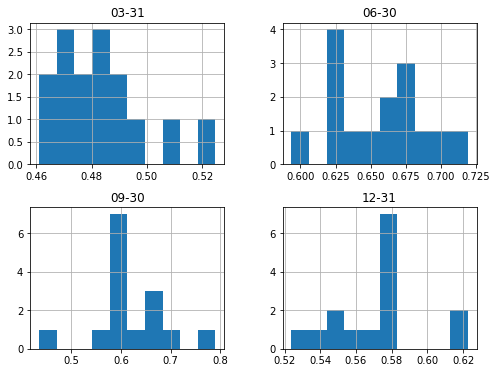

In [157]:
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()

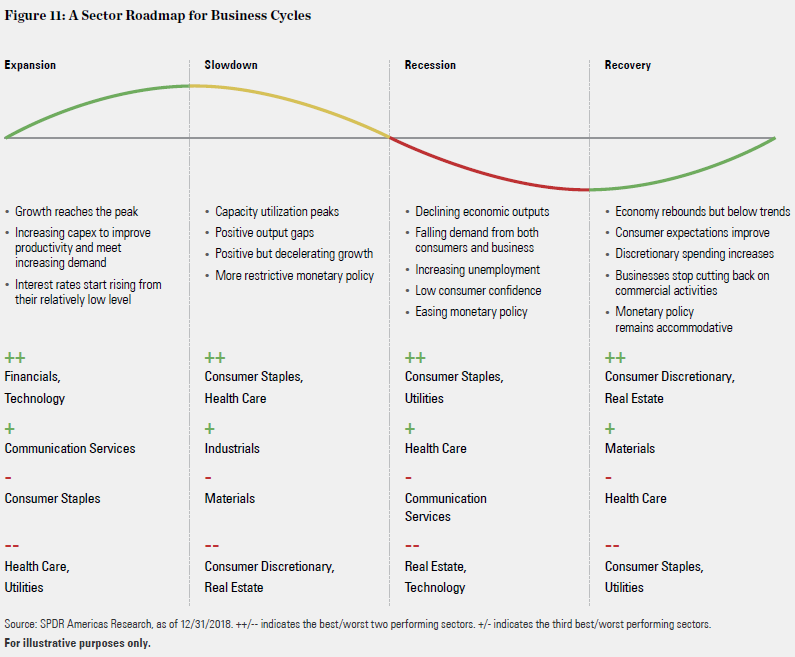

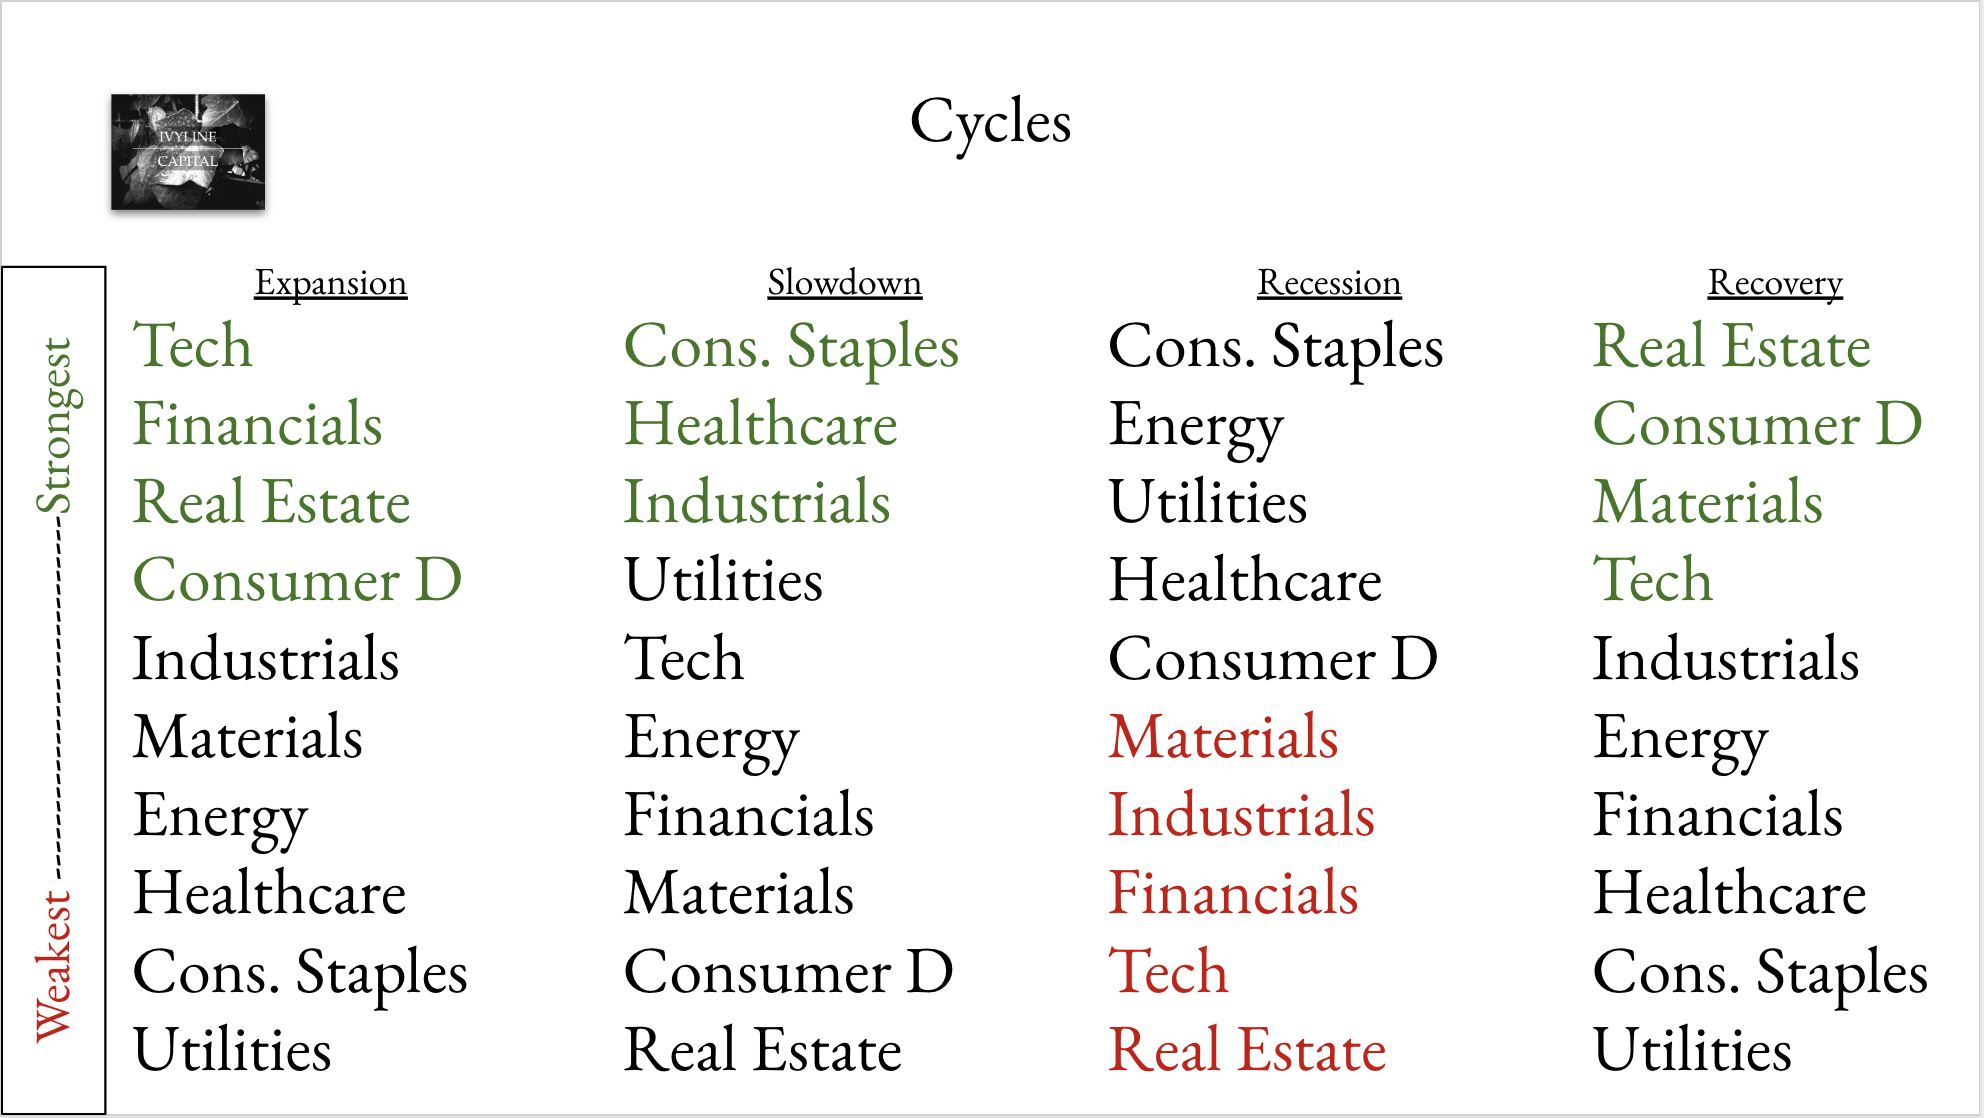

In [158]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [159]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


In [160]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [161]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

Index Symbol  risk_trend_factor
0   SP500    SPY          -3.322122
1  SP1500   SPTM          -3.343750
2   SP400   MDYG          -4.411325
3   SP600    SLY          -4.590014

In [162]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

Symbol  risk_trend_factor                      Sector
3     VDE           0.462556                  Energy ETF
2     VDC          -2.028745        Consumer Staples ETF
10    VPU          -2.228331               Utilities ETF
8     VAW          -2.769405               Materials ETF
5     VHT          -2.850492             Health Care ETF
9     VNQ          -2.915234             Real Estate ETF
4     VFH          -3.976216              Financials ETF
6     VIS          -4.047714             Industrials ETF
1     VCR          -4.153733  Consumer Discretionary ETF
7     VGT          -4.418808  Information Technology ETF
0     VOX          -7.422475  Communication Services ETF

Rolling Quarterly Mean Return


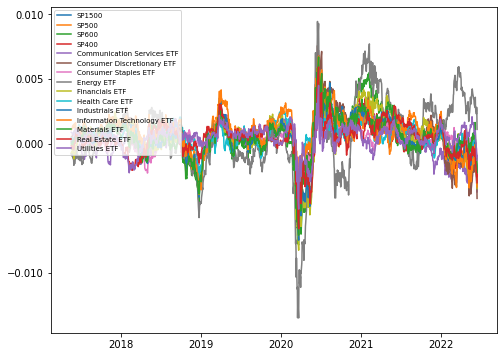

In [163]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


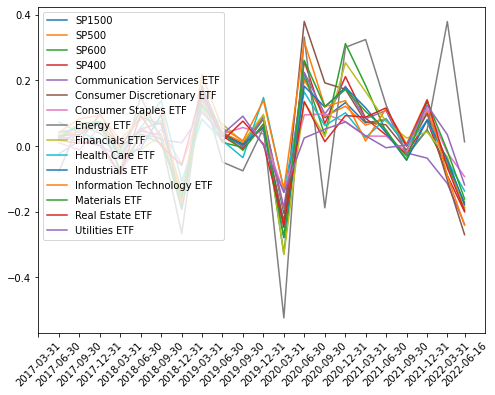

In [164]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


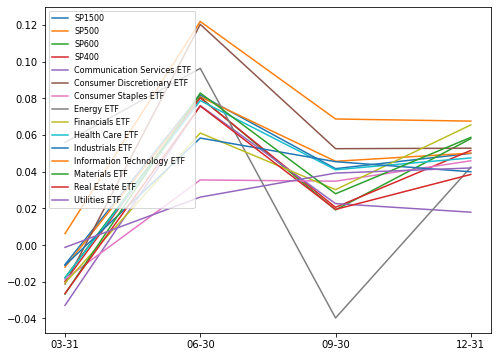

In [165]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [166]:
threshold = .975

In [167]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [168]:
risk_trend_threshold

0.2346399907935845

In [169]:
stock_sectors = stock_fundamentals['sector']

In [170]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

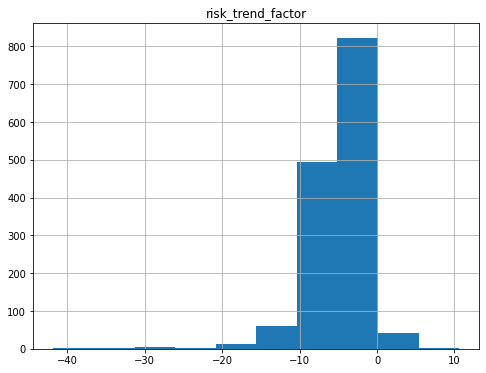

In [171]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [172]:
len(screener)

1520

In [173]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
display(risk_screened[['Symbol','latest_p','risk_trend_factor','adf','hurst','Sector','Market Index','vol_30d_2yr']])

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'volume_factor', 'adf', 'hurst',
       '1YMF', 'Market Index', 'Sector'],
      dtype='object')


Symbol    latest_p risk_trend_factor       adf     hurst  \
0     ACC   64.099998         10.609763  0.977604  0.419621   
1    MTOR       35.91          4.956529   0.29595   0.43549   
2    TVTY   32.099998           2.26495  0.517984  0.449082   
3       Y   830.47998          2.012295  0.382778  0.459301   
4    SAFM  206.449997          1.545589  0.651375  0.476748   
5    BANF   91.559998          1.522781  0.918694  0.536414   
6     PBF       35.09          1.214106  0.622395  0.555912   
7     TWI       18.08          1.188361  0.834351  0.500331   
8    CEIX   49.060001          1.103516  0.891799  0.522582   
9    LNTH   59.540001          1.052988  0.957446  0.533091   
10     GO   40.450001          0.992056  0.177952  0.402887   
11    XOM   91.389999          0.949011  0.916245  0.534339   
12    MCK  304.019989            0.9363  0.997806  0.461676   
13    COP  102.419998          0.839988  0.929388   0.48705   
14    HRB       33.27          0.825493   0.68658  0.435784   
15     SM   43.299999          0.776368  0.889778  0.475064   
16    DVN       63.27          0.769026  0.955415  0.547561   
17    ROG  257.079987          0.729041  0.707598  0.478685   
18    SJI   33.759998          0.666664  0.156179  0.415159   
19    APA   41.759998          0.662665  0.332977  0.446771   
20    MPC   91.980003          0.658939  0.710335   0.51907   
21   DINO       47.77          0.622034  0.504978  0.561898   
22    MRO       25.66          0.621752  0.862619  0.540113   
23   MTDR   56.040001           0.61596  0.921632  0.464965   
24   ROCC   41.779999          0.612375  0.601456  0.578912   
25    VLO  118.739998           0.56008  0.703807  0.534876   
26    PSB  185.740005          0.552514  0.808632  0.476969   
27   CIVI   66.389999           0.47854  0.000353  0.475979   
28    VDE  108.400002          0.462556  0.733758  0.517254   
29    WRB   66.300003          0.379041  0.938034  0.452933   
30   PDCE   72.650002          0.347614  0.542285  0.491711   
31   FANG  133.679993          0.304849  0.668762  0.470333   
32   MANT   94.690002          0.303582  0.565273  0.363266   
33    FCN  162.949997          0.286702  0.916688  0.405187   
34    OXY   56.810001          0.244336  0.695678  0.543336   
35    EOG  119.559998           0.24174  0.682764  0.481992   

                Sector Market Index       vol_30d_2yr  
0                error        SP400    26979850.78125  
1                error        SP600   15439291.992188  
2                error        SP600   10912294.921875  
3   Financial Services        SP400        1621906.25  
4   Consumer Defensive        SP400     5064230.46875  
5   Financial Services        SP600      2480129.6875  
6               Energy        SP600   92708582.421875  
7          Industrials        SP600   10535892.773438  
8               Energy        SP600   10281161.132812  
9           Healthcare        SP600   14113253.515625  
10  Consumer Defensive        SP400    21743692.96875  
11               error        SP500  552368724.023438  
12          Healthcare        SP500   22892569.726562  
13              Energy        SP500  189223264.453125  
14   Consumer Cyclical        SP400   54246410.742188  
15              Energy        SP600       85523868.75  
16              Energy        SP500   237831403.90625  
17               error        SP600    3248152.734375  
18               error        SP600    26835210.15625  
19              Energy        SP500  204947064.257812  
20              Energy        SP500  141887166.210938  
21              Energy        SP400     51415267.1875  
22              Energy        SP500  490913172.265625  
23              Energy        SP400   48834102.929688  
24              Energy        SP600        12003625.0  
25              Energy        SP500   90493904.492188  
26               error        SP400    2715957.617188  
27              Energy        SP600   11253325.390625  
28               error          NaN      257946

In [174]:

screened_final_set = risk_screened

In [175]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [176]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [177]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [178]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

In [179]:
dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

In [180]:
dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [181]:
def evaluate_ets(npa_):
    train,test,model_func,flag_ = npa_
    
    try:
        if(len(flag)==2):
            if(flag[1] is None):
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=train.index).fit()
            else:
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=train.index).fit()
        else:
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=train.index).fit()

        fc_ets_ = np.exp(model.get_prediction(start=test.index[0],end=test.index[-1]).summary_frame())
        rmse_ = mean_squared_error(test, fc_ets_['mean'], squared=True)
    except:
        #not enough data points
        rmse_ = np.nan
    
    return([flag,rmse_])

In [182]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

nominal, pct_change, pct_change().cumsum
Market volatility


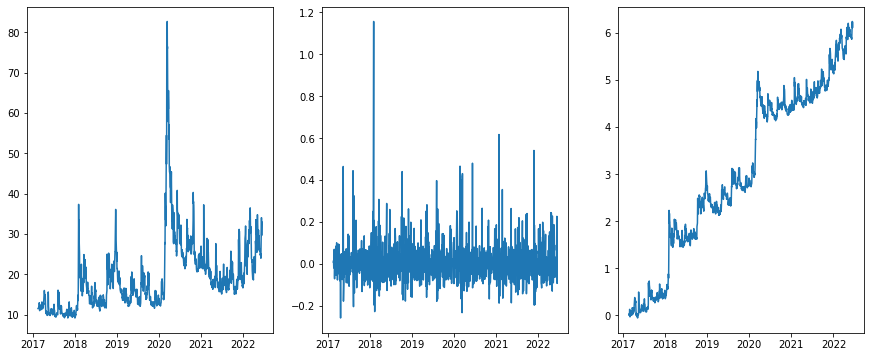

Consumer Confidence


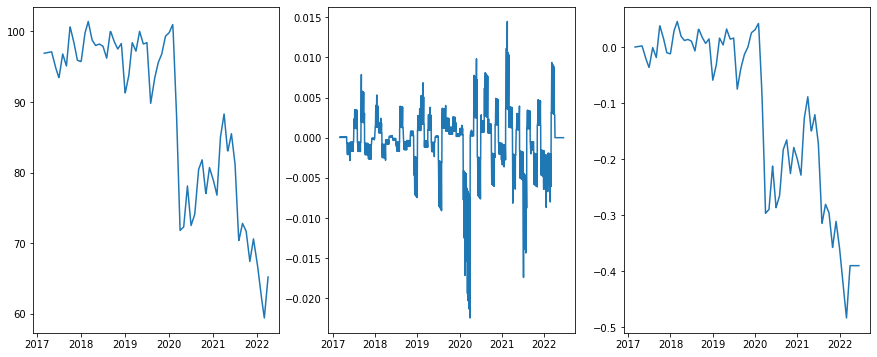

Unemployment


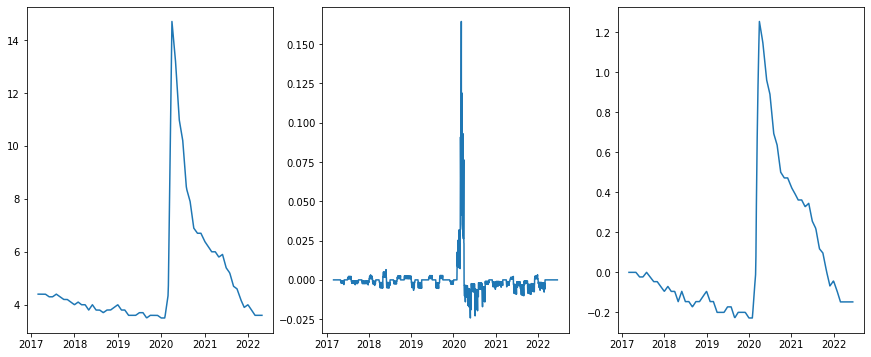

Inflation


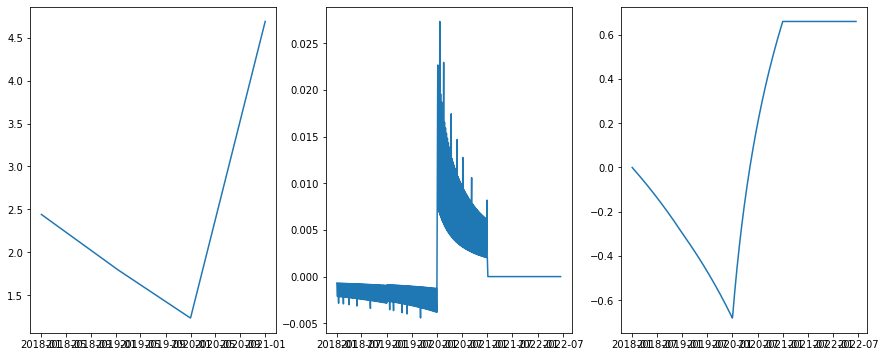

Interest Rates


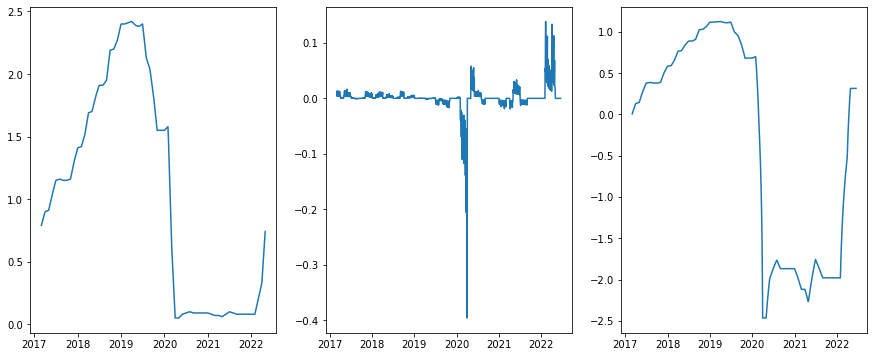

10 Year to 3 Month


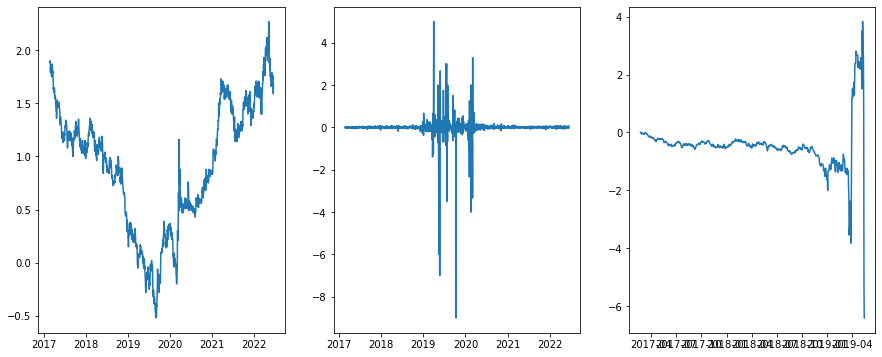

Recession Indicator


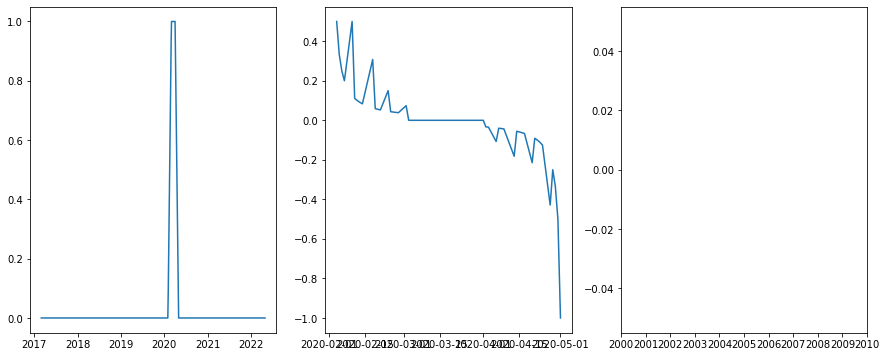

In [183]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [184]:
#screener['vol_30d_2yr']

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: SPY
sector: error
sector: error
Index: SP500
vol_30d_2yr: 1719865437.6953125
Sector 1YMF: -285.47003173828125
1YMF: -285.47003173828125
risk trend factor: -3.322122130654123
      totalAssets  trailingPE
SPY  3.710190e+11    2.538166


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  366.649994  369.000236  397.879841  426.759446  420.668572   

              90dSDev   90d_lower   90d_upper  
2022-06-16  24.765352  371.137868  470.199277

volume_factor    latest_p        vol_30d_2yr  pct_2yr       adf     hurst
SPY      1.187217  366.649994  1719865437.695312  0.37404  0.668152  0.422436

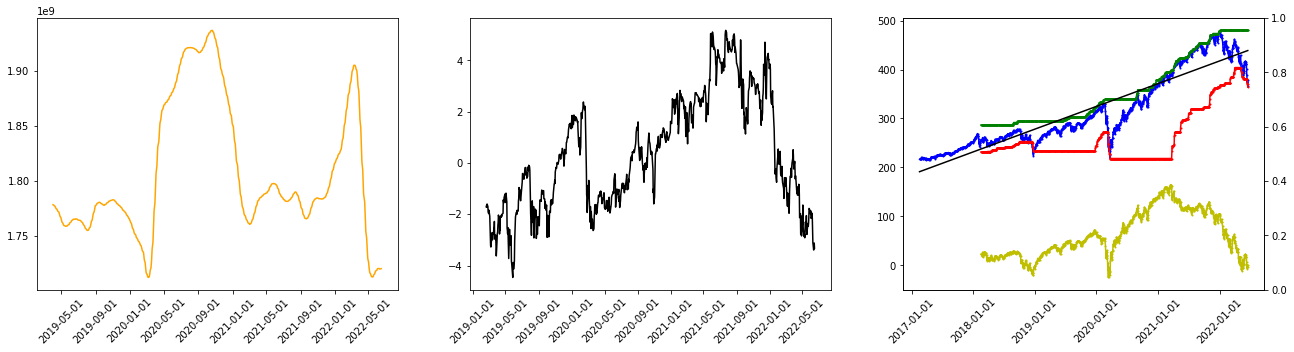

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 900.8255729001365 691.1877332173517
test cv mean error, stdev (10 folds): 947.3979204155439 708.2791359713194
sell date: 2022-08-28
expected return: 0.09779109831779359
discounted return: 0.0012966742399809217
quarter return: 1.126614090075292


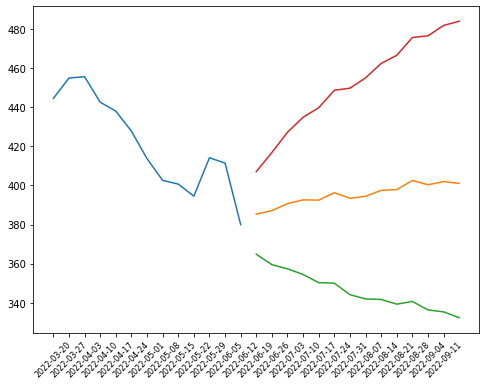

['options', ('2022-06-17', '2022-06-30', '2022-09-16', '2022-09-30', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15', '2024-01-19', '2024-12-20')]
symbol: SPTM
sector: error
sector: error
Index: SP1500
vol_30d_2yr: 10178996.6796875
Sector 1YMF: -35.31000900268555
1YMF: -35.31000900268555
risk trend factor: -3.3437504176840096
       totalAssets
SPTM  5.538233e+09


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  45.189999  45.493599  49.085238  52.676877  51.837778  3.005692   

            90d_lower  90d_upper  
2022-06-16  45.826394  57.849161

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SPTM      1.613175  45.189999  10178996.679688  0.382941  0.660777  0.429302

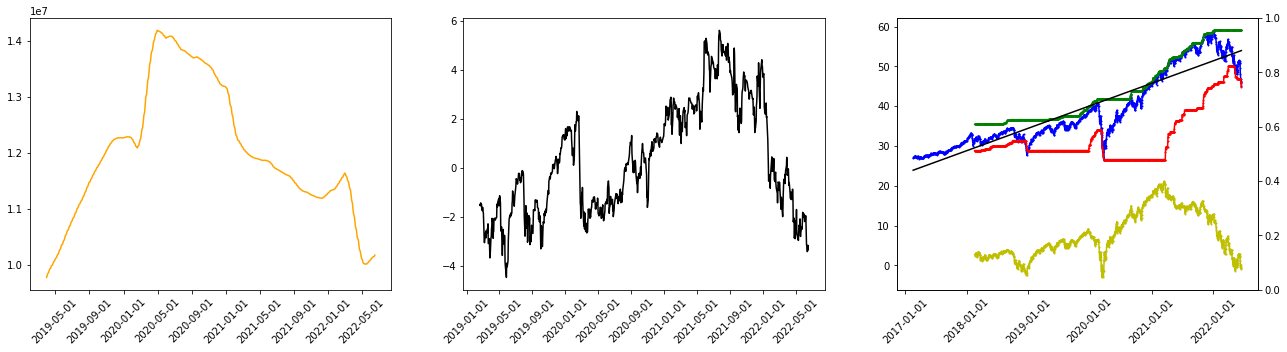

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 14.385067335438295 11.7776188121974
test cv mean error, stdev (10 folds): 15.153048662666269 12.087009213381313
sell date: 2022-08-28
expected return: 0.06116742222449132
discounted return: 0.0008249184445154878
quarter return: 1.0788128369935377


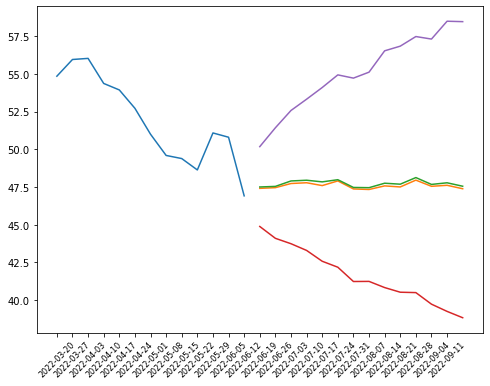

['options', ('2022-06-17',)]
symbol: MDYG
sector: error
sector: error
Index: SP400
vol_30d_2yr: 4966221.6796875
Sector 1YMF: -70.88999938964844
1YMF: -70.88999938964844
risk trend factor: -4.411325496943257
Empty DataFrame
Columns: []
Index: [MDYG]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     59.32  60.264492  65.645397  71.026302  69.286825  4.228363   

           90d_lower  90d_upper  
2022-06-16   60.8301  77.743551

volume_factor latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MDYG      0.566245    59.32  4966221.679688  0.237412  0.497173  0.451359

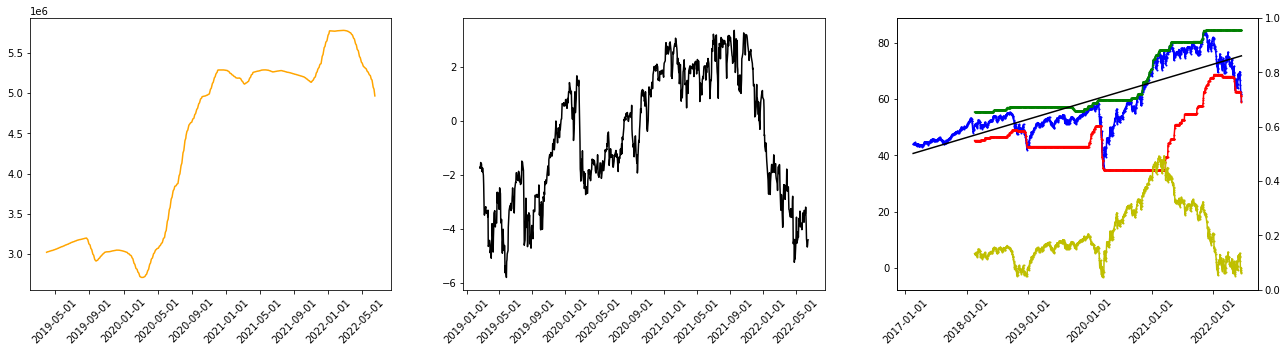

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 44.77116239403053 49.782598109890024
test cv mean error, stdev (10 folds): 48.33338950551348 50.85817154408968
sell date: 2022-09-18
expected return: 0.1278630858607739
discounted return: 0.0012946520482137736
quarter return: 1.1264047836005713


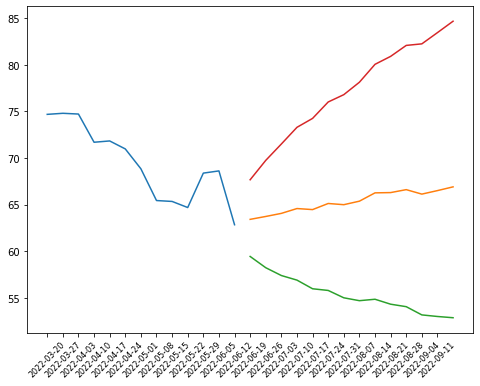

['options', ('2022-06-17',)]
symbol: SLY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 1809732.8125
Sector 1YMF: -79.04000854492188
1YMF: -79.04000854492188
risk trend factor: -4.590013818867828
Empty DataFrame
Columns: []
Index: [SLY]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16      77.5  79.070455  85.374285  91.678116  88.497619  4.367275   

            90d_lower 90d_upper  
2022-06-16  79.763069  97.23217

volume_factor latest_p   vol_30d_2yr   pct_2yr       adf     hurst
SLY      1.243664     77.5  1809732.8125  0.437588  0.531287  0.513642

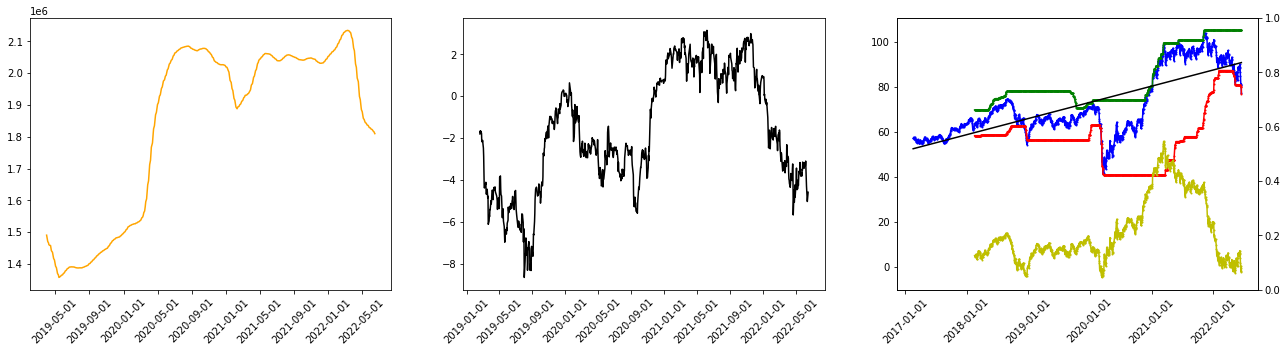

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 84.60402975821997 83.69624498551492
test cv mean error, stdev (10 folds): 90.26006064882574 85.75353983896113
sell date: 2022-08-14
expected return: 0.09435383799012423
discounted return: 0.0015557621648785158
quarter return: 1.153751603095759


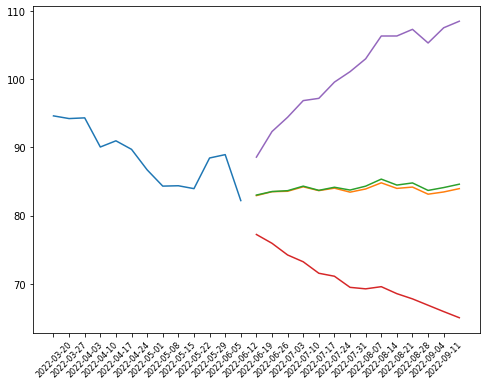

symbol: VDE
sector: error
sector: Energy
Index: nan
vol_30d_2yr: 25794671.875
Sector 1YMF: 14.330001831054688
1YMF: 14.330001831054688
risk trend factor: 0.4625564970394849
      totalAssets  trailingPE
VDE  9.791998e+09    8.720438


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  108.400002  109.091942  119.897302  130.702662  112.549524   

             90dSDev  90d_lower   90d_upper  
2022-06-16  6.711476  99.126572  125.972476

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VDE      0.827969  108.400002  25794671.875  0.765817  0.733758  0.517254

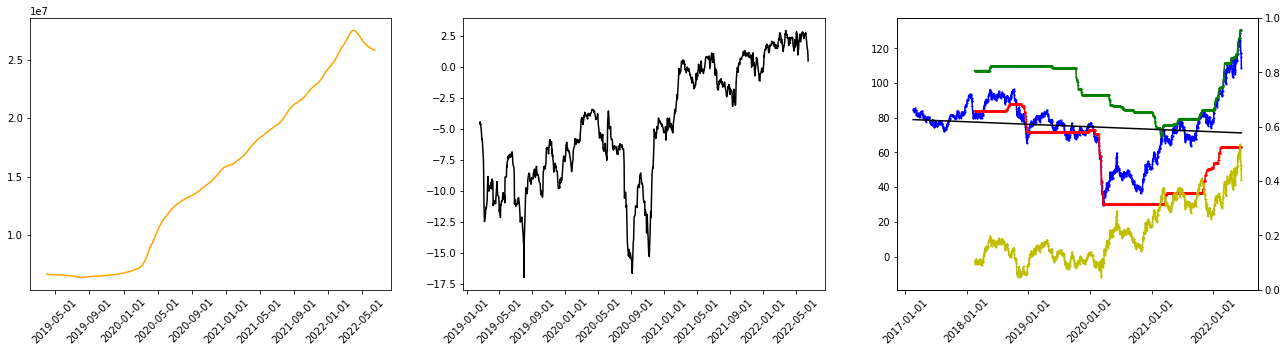

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 154.91171156477313 205.2085913123838
test cv mean error, stdev (10 folds): 169.90052434704552 209.4046631486799
sell date: 2022-09-18
expected return: 0.19786552676250987
discounted return: 0.001943189262701539
quarter return: 1.1955423616821854


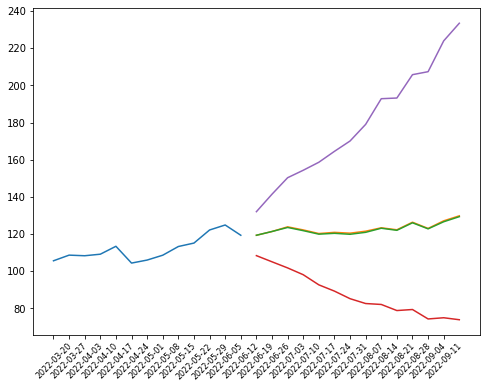

['options', ('2022-06-17',)]
symbol: VDC
sector: error
sector: Consumer Defensive
Index: nan
vol_30d_2yr: 3268846.484375
Sector 1YMF: -69.8699951171875
1YMF: -69.8699951171875
risk trend factor: -2.02874535900685
      totalAssets
VDC  8.239956e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  177.660004  177.374402  186.335397  195.296392  194.919525   

             90dSDev   90d_lower   90d_upper  
2022-06-16  7.598617  179.722291  210.116758

volume_factor    latest_p     vol_30d_2yr pct_2yr       adf     hurst
VDC      1.480492  177.660004  3268846.484375  0.4983  0.764603  0.355847

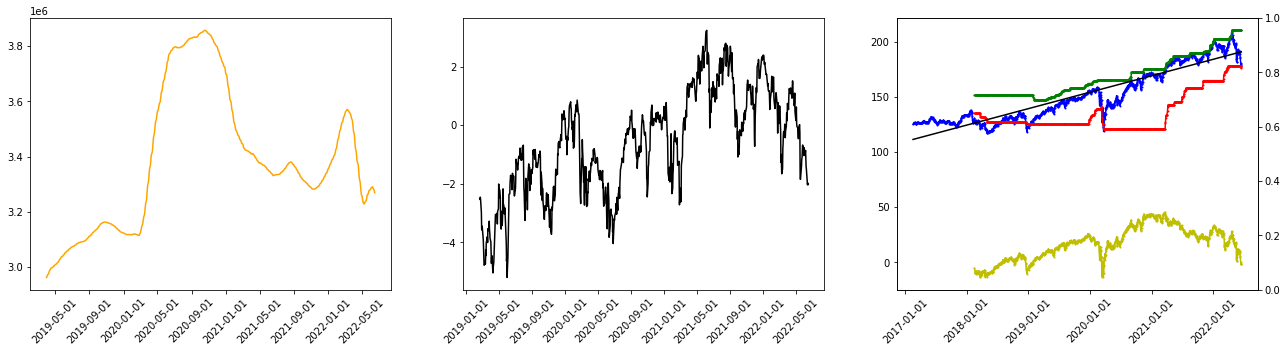

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 90.81052485722661 59.81314897701307
test cv mean error, stdev (10 folds): 92.1432809448846 62.57657938551701
sell date: 2022-07-24
expected return: 0.04768406792305951
discounted return: 0.0012597679376336046
quarter return: 1.1228001609062328


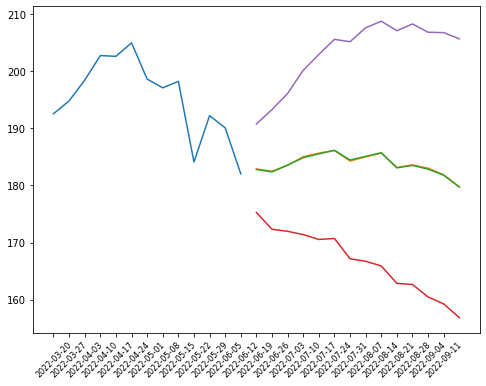

['options', ('2022-07-15',)]
symbol: VPU
sector: error
sector: Utilities
Index: nan
vol_30d_2yr: 5029426.5625
Sector 1YMF: -55.529998779296875
1YMF: -55.529998779296875
risk trend factor: -2.228330772852824
      totalAssets
VPU  7.854255e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  142.639999  145.026922  157.167143  169.307365  158.766666   

             90dSDev   90d_lower   90d_upper  
2022-06-16  5.333557  148.099552  169.433781

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VPU      1.238869  142.639999  5029426.5625  0.476943  0.575311  0.291623

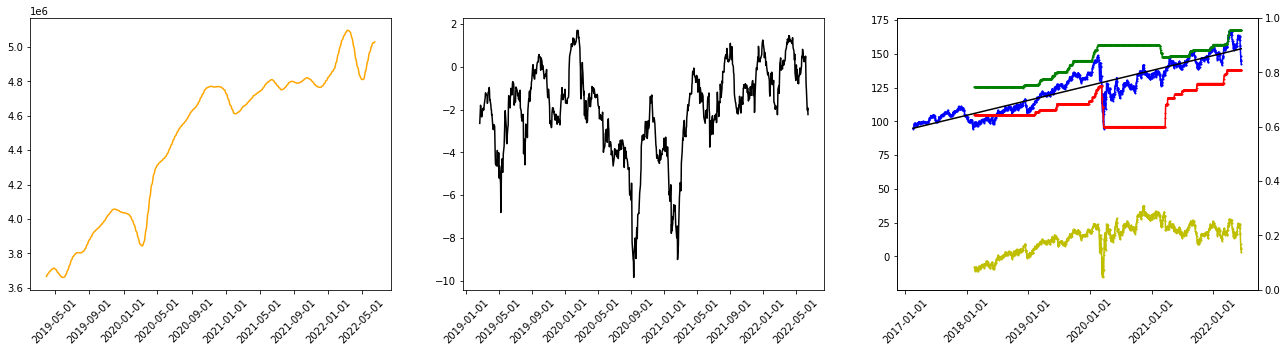

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 67.54983737949375 79.57052571797756
test cv mean error, stdev (10 folds): 71.5413908624557 82.39756511657437
sell date: 2022-06-19
expected return: 0.05952245240776661
discounted return: 0.02933107035966165
quarter return: 14.291162520526449


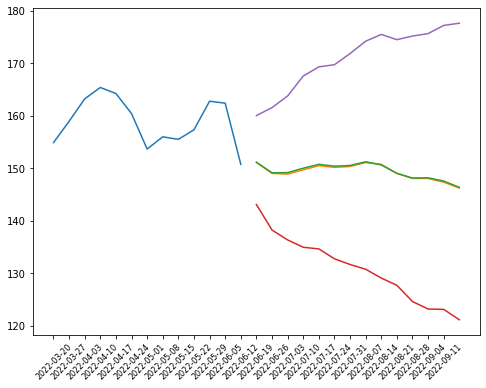

['options', ('2022-06-17',)]
symbol: VAW
sector: error
sector: Basic Materials
Index: nan
vol_30d_2yr: 2683957.03125
Sector 1YMF: -109.88999938964844
1YMF: -109.88999938964844
risk trend factor: -2.769404672772488
      totalAssets
VAW  5.085875e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16    162.75  166.399295  182.418888  198.438482  187.714921   

             90dSDev   90d_lower   90d_upper  
2022-06-16  7.971112  171.772698  203.657145

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VAW      0.997818   162.75  2683957.03125  0.552809  0.655014  0.425897

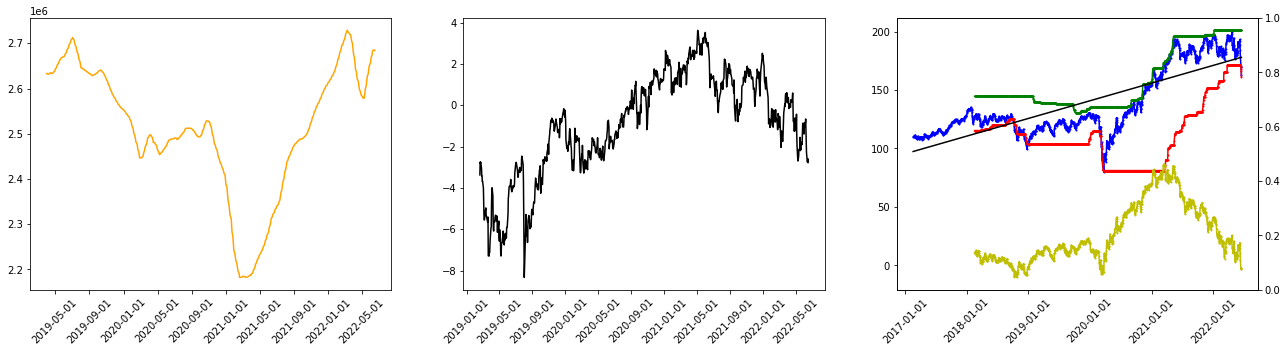

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 207.70738265136504 132.65825138883528
test cv mean error, stdev (10 folds): 223.6764419754035 128.65814736552585
sell date: 2022-07-10
expected return: 0.1119318183260182
discounted return: 0.004623651000345452
quarter return: 1.5286660891466681


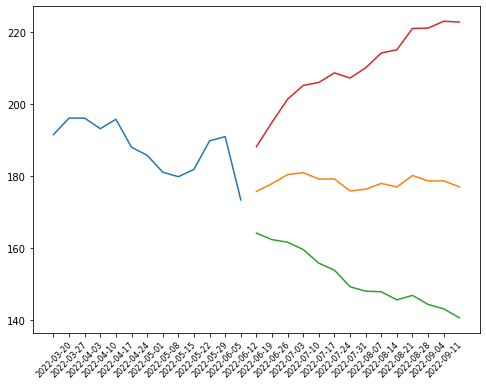

['options', ('2022-08-19',)]
symbol: VHT
sector: error
sector: Healthcare
Index: nan
vol_30d_2yr: 5367363.8671875
Sector 1YMF: -124.31001281738281
1YMF: -124.31001281738281
risk trend factor: -2.8504922628415557
      totalAssets  trailingPE
VHT  1.866525e+10     4.76247


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  219.509995  220.654154  235.040794  249.427434  244.335872   

              90dSDev   90d_lower   90d_upper  
2022-06-16  11.224845  221.886182  266.785562

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf   hurst
VHT      1.214414  219.509995  5367363.867188  0.39819  0.637303  0.3325

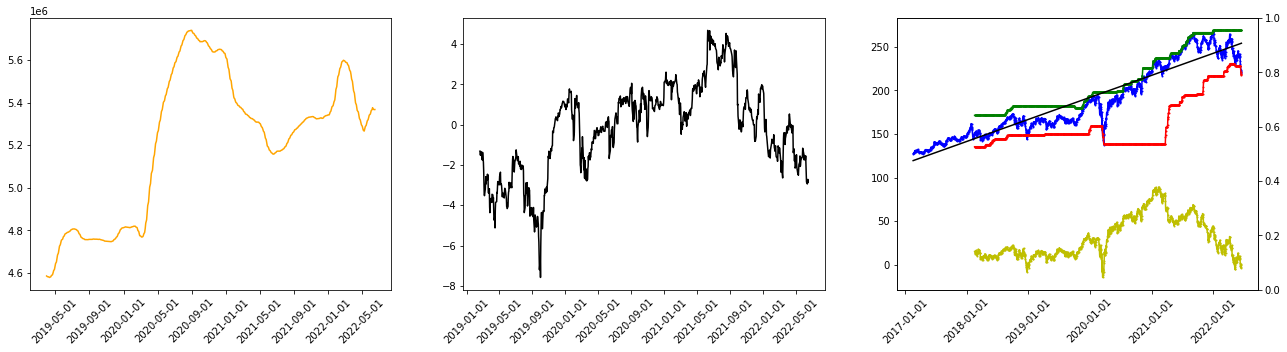

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 279.5978770253289 226.12512182809652
test cv mean error, stdev (10 folds): 277.2864584836826 237.03809276595766
sell date: 2022-08-28
expected return: 0.049295339393070646
discounted return: 0.0006685405061188643
quarter return: 1.0634147325506256


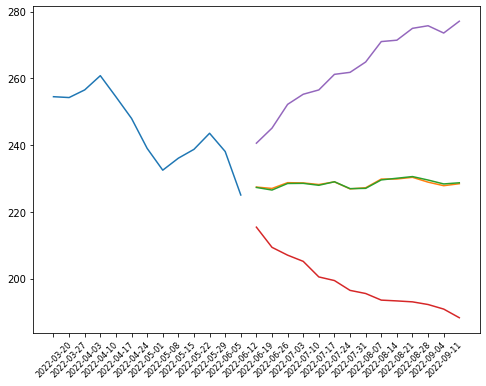

['options', ('2022-06-17',)]
symbol: VNQ
sector: error
sector: Real Estate
Index: nan
vol_30d_2yr: 102987975.5859375
Sector 1YMF: -78.06999206542969
1YMF: -78.06999206542969
risk trend factor: -2.915234256258139
      totalAssets
VNQ  7.839537e+10


Adj Close    21dBOLD   21dMA-TP     21dBOLU      90dSMA   90dSDev  \
2022-06-16  87.040001  87.570691  95.275873  102.981056  102.085397  6.981869   

            90d_lower   90d_upper  
2022-06-16  88.121659  116.049135

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
VNQ      1.205023  87.040001  102987975.585938  0.280727  0.448402  0.395581

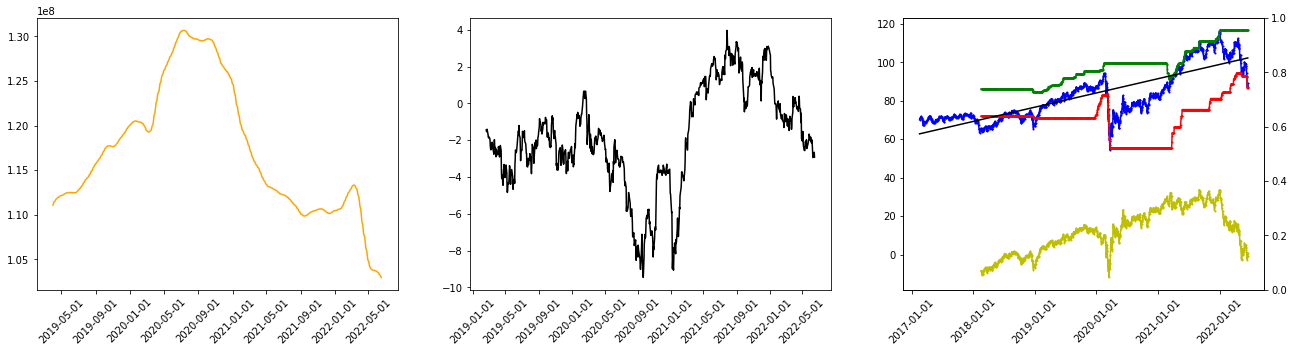

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', True]
best inner cv score, sdev (11 folds): 74.07196505972851 107.14799507369915
test cv mean error, stdev (10 folds): 78.54723351089628 111.39324023538671
sell date: 2022-06-19
expected return: 0.029626841200132554
discounted return: 0.01470529770970086
quarter return: 3.830657804920116


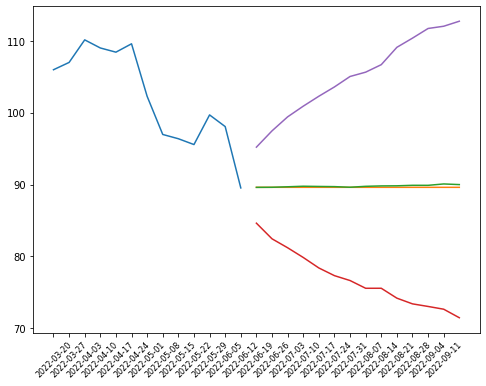

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: VFH
sector: error
sector: Financial Services
Index: nan
vol_30d_2yr: 16527203.7109375
Sector 1YMF: -73.55999755859375
1YMF: -73.55999755859375
risk trend factor: -3.976216084248311
      totalAssets
VFH  1.046217e+10


Adj Close    21dBOLD   21dMA-TP 21dBOLU     90dSMA   90dSDev  \
2022-06-16  75.419998  75.781429  82.755715   89.73  87.139048  5.472163   

            90d_lower  90d_upper  
2022-06-16  76.194721  98.083374

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VFH      1.217683  75.419998  16527203.710938  0.429233  0.482221  0.491488

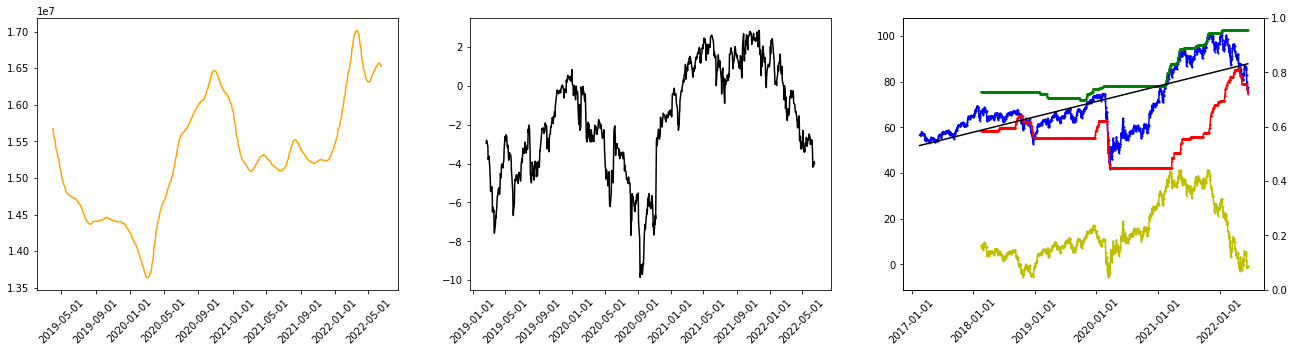

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 60.09383639547041 57.615450340053094
test cv mean error, stdev (10 folds): 63.924860649057884 59.07753873960204
sell date: 2022-08-28
expected return: 0.06890778554346759
discounted return: 0.0009259473966229947
quarter return: 1.0888779315240102


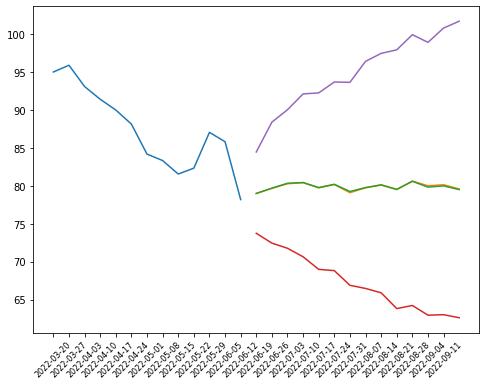

['options', ('2022-08-19',)]
symbol: VIS
sector: error
sector: Industrials
Index: nan
vol_30d_2yr: 3375701.3671875
Sector 1YMF: -141.6699981689453
1YMF: -141.6699981689453
risk trend factor: -4.0477142333984375
Empty DataFrame
Columns: []
Index: [VIS]


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  159.779999  161.379178  173.219365  185.059552  181.926032   

             90dSDev   90d_lower   90d_upper  
2022-06-16  9.652982  162.620068  201.231995

volume_factor    latest_p     vol_30d_2yr   pct_2yr      adf     hurst
VIS      0.873152  159.779999  3375701.367188  0.424826  0.48671  0.470783

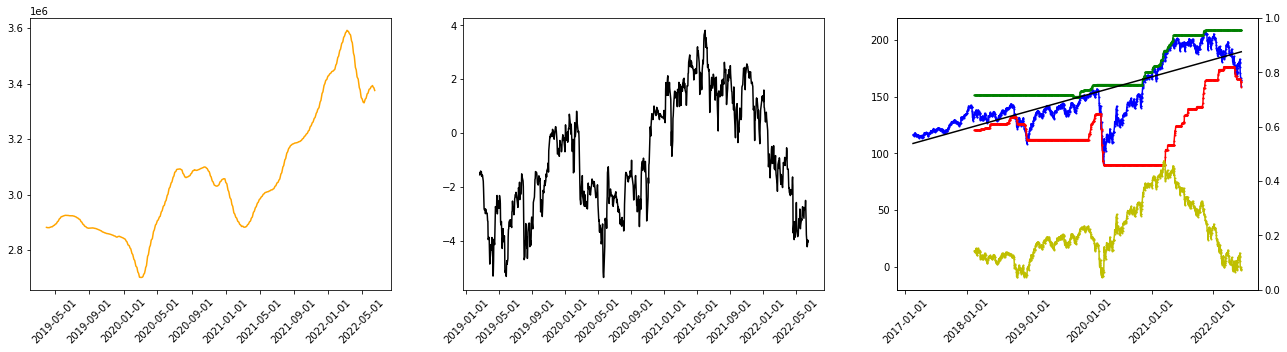

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 280.89042894226026 336.00159009704754
test cv mean error, stdev (10 folds): 303.7883179277397 344.1210971356311
sell date: 2022-08-28
expected return: 0.09023316926232705
discounted return: 0.001200603343935569
quarter return: 1.11671267078747


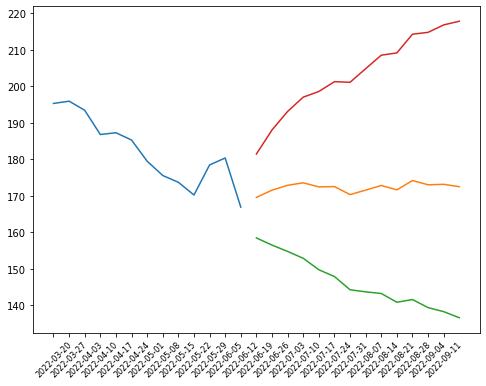

['options', ('2022-08-19',)]
symbol: VCR
sector: error
sector: Consumer Cyclical
Index: nan
vol_30d_2yr: 2593840.625
Sector 1YMF: -369.34999084472656
1YMF: -369.34999084472656
risk trend factor: -4.1537329629948685
      totalAssets
VCR  5.266340e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  222.740005  220.387534  243.676825  266.966116  272.364761   

              90dSDev   90d_lower   90d_upper  
2022-06-16  27.808722  216.747317  327.982206

volume_factor    latest_p  vol_30d_2yr   pct_2yr       adf     hurst
VCR       1.29634  222.740005  2593840.625  0.187308  0.636286  0.472995

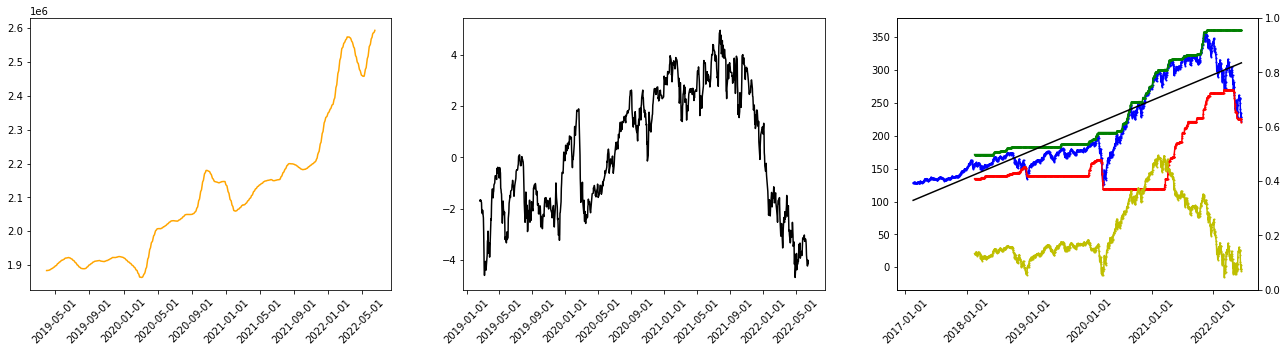

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 952.8830367315925 971.9508949262715
test cv mean error, stdev (10 folds): 1040.9427026546284 976.6564005616518
sell date: 2022-07-24
expected return: 0.051526277571769454
discounted return: 0.0013588333625320637
quarter return: 1.1330666546262926


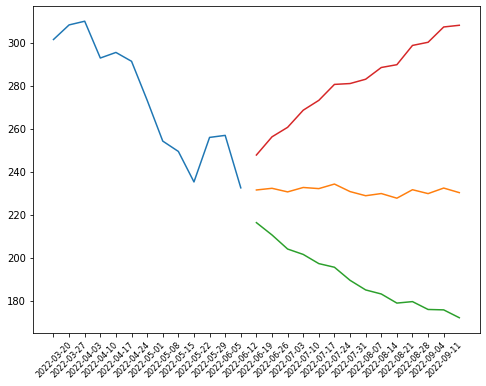

['options', ('2022-06-17',)]
symbol: VGT
sector: error
sector: Technology
Index: nan
vol_30d_2yr: 14315855.2734375
Sector 1YMF: -374.97998046875
1YMF: -374.97998046875
risk trend factor: -4.4188079801718425
      totalAssets
VGT  5.044675e+10


Adj Close     21dBOLD    21dMA-TP   21dBOLU      90dSMA  \
2022-06-16  315.970001  316.754058  346.341429  375.9288  373.130002   

              90dSDev   90d_lower   90d_upper  
2022-06-16  29.399875  314.330253  431.929751

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VGT      1.137257  315.970001  14315855.273438  0.243036  0.683578  0.429242

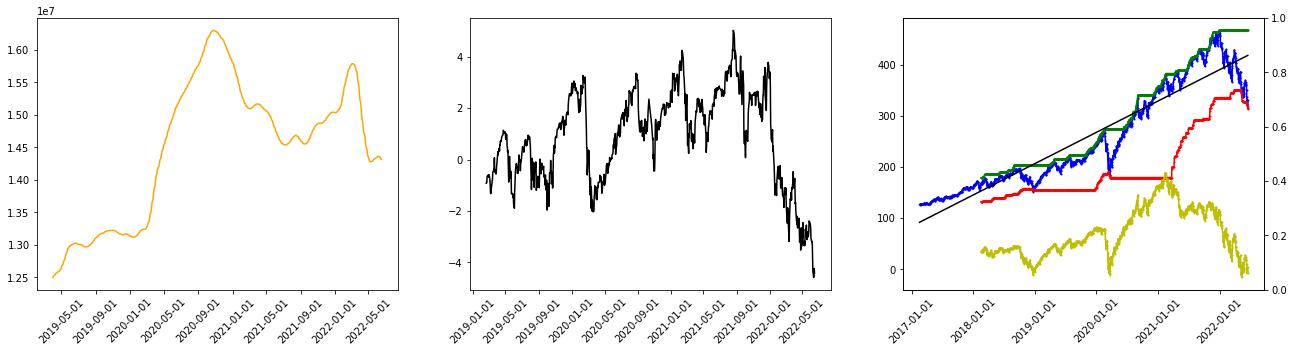

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 1107.692443241078 925.5522391639219
test cv mean error, stdev (10 folds): 1169.731103675255 948.6704684477432
sell date: 2022-09-11
expected return: 0.12687167601232358
discounted return: 0.0013898645634560225
quarter return: 1.136301582712567


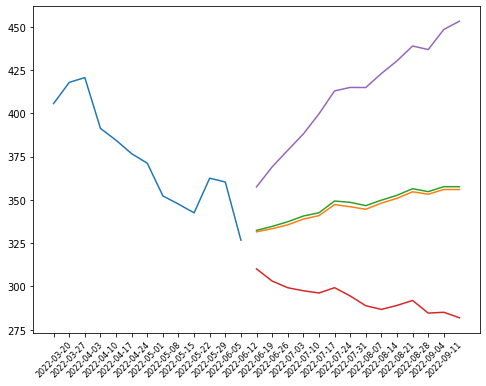

['options', ('2022-06-17', '2022-08-19')]
symbol: VOX
sector: error
sector: Communication Services
Index: nan
vol_30d_2yr: 4638787.3046875
Sector 1YMF: -170.42001342773438
1YMF: -170.42001342773438
risk trend factor: -7.422474748397777
Empty DataFrame
Columns: []
Index: [VOX]


Adj Close    21dBOLD   21dMA-TP    21dBOLU      90dSMA   90dSDev  \
2022-06-16  91.389999  92.452696  99.803968  107.15524  107.854286  9.210231   

            90d_lower   90d_upper  
2022-06-16  89.433824  126.274748

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VOX      1.812392  91.389999  4638787.304688  0.036059  0.712116  0.512455

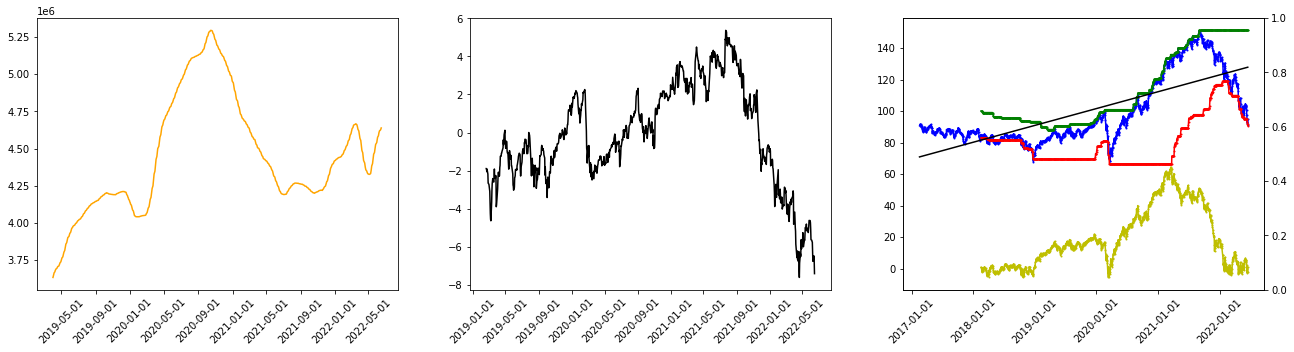

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 94.1071211050367 85.09095555247727
test cv mean error, stdev (10 folds): 100.46603325999953 86.71634414899984
sell date: 2022-09-11
expected return: 0.07184116996887799
discounted return: 0.000807045129171513
quarter return: 1.0770417981201434


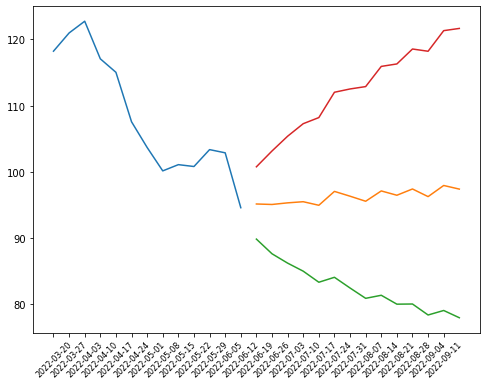

['options', ('2022-07-15',)]
symbol: ACC
sector: error
sector: error
Index: SP400
vol_30d_2yr: 26979850.78125
Sector 1YMF: 13.050003051757812
1YMF: 13.050003051757812
risk trend factor: 10.609762527253386
Empty DataFrame
Columns: []
Index: [ACC]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  64.099998  64.286211  64.725873  65.165535  61.940476  3.999624   

            90d_lower  90d_upper  
2022-06-16  53.941228  69.939724

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
ACC      2.234901  64.099998  26979850.78125  0.967203  0.977604  0.419621

Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


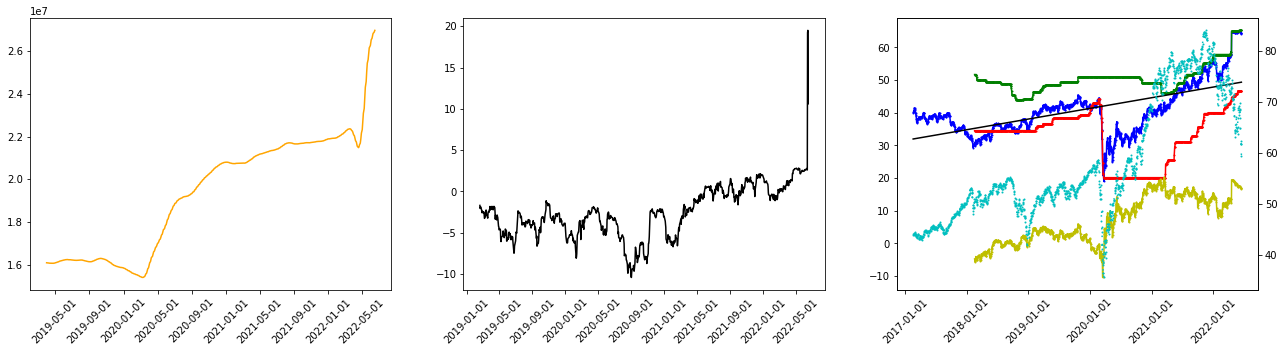

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 17.38153804293795 12.102196457408603
test cv mean error, stdev (10 folds): 18.103170393774633 12.465199304426951
sell date: 2022-07-17
expected return: 0.031424384685890684
discounted return: 0.0010318901884582843
quarter return: 1.0995323470136884


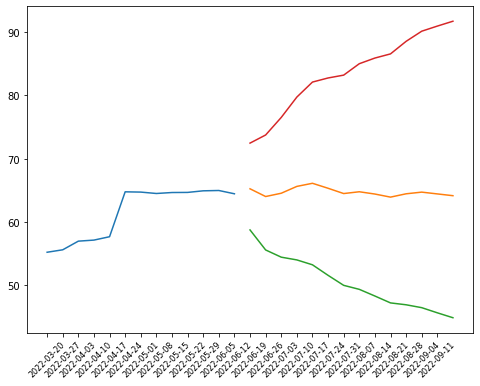

['options', ('2022-06-17',)]
symbol: MTOR
sector: error
sector: error
Index: SP600
vol_30d_2yr: 15439291.9921875
Sector 1YMF: 2.279998779296875
1YMF: 2.279998779296875
risk trend factor: 4.956528950292737
Empty DataFrame
Columns: []
Index: [MTOR]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     35.91  35.940106  36.098412  36.256718  35.878095  0.246654   

            90d_lower  90d_upper  
2022-06-16  35.384787  36.371403

volume_factor latest_p      vol_30d_2yr   pct_2yr      adf    hurst
MTOR      1.642038    35.91  15439291.992188  0.978501  0.29595  0.43549

Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


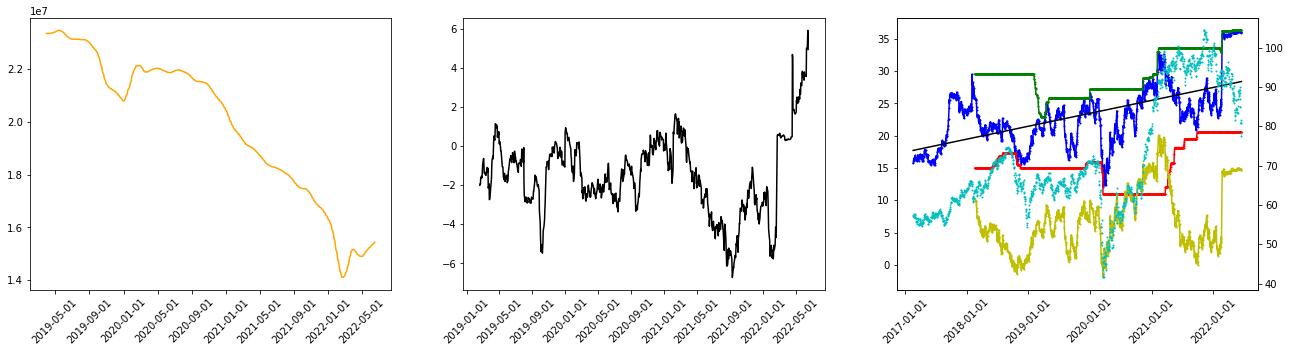

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 16.12034837148428 9.392302279151806
test cv mean error, stdev (10 folds): 15.624875348370711 9.712693915607272
sell date: 2022-09-18
expected return: 0.0050908158241922035
discounted return: 5.4602581340157386e-05
quarter return: 1.0050359382676266


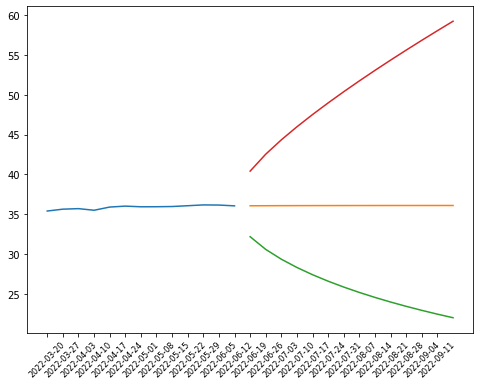

['options', ('2022-08-19',)]
symbol: TVTY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 10912294.921875
Sector 1YMF: 2.649995803833008
1YMF: 2.649995803833008
risk trend factor: 2.2649498384462143
Empty DataFrame
Columns: []
Index: [TVTY]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  32.099998  31.873617  32.188889  32.504161  31.814762  0.890507   

            90d_lower  90d_upper  
2022-06-16  30.033748  33.595776

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TVTY      1.652237  32.099998  10912294.921875  0.965198  0.517984  0.449082

Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


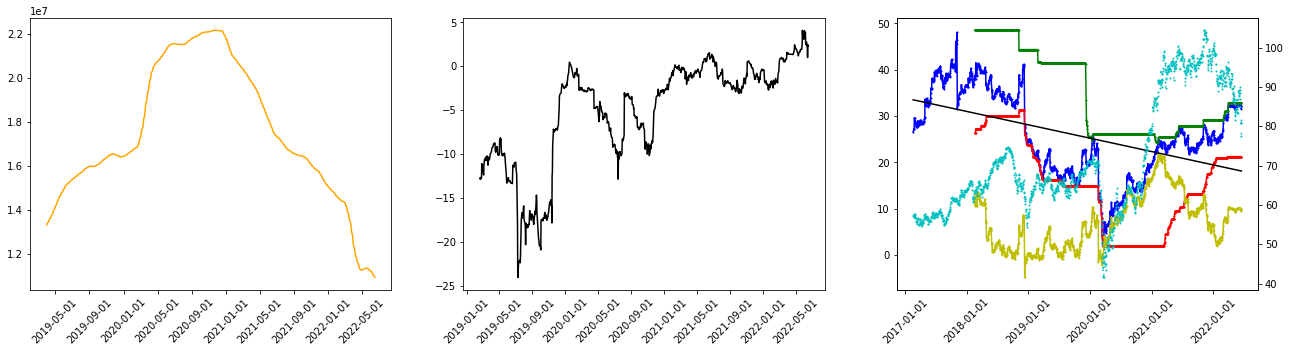

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 23.87776531489791 20.845468653787997
test cv mean error, stdev (10 folds): 25.778478281237447 20.934352374272137
sell date: 2022-08-07
expected return: 0.08489415900400657
discounted return: 0.001598971757586165
quarter return: 1.1583399681425293


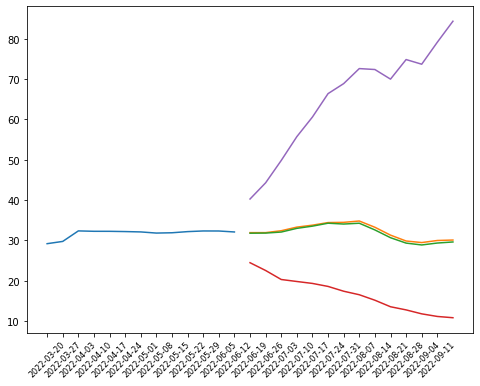

['options', ('2022-08-19',)]
symbol: Y
sector: Financial Services
Index: SP400
vol_30d_2yr: 1621906.25
Sector 1YMF: 27.8099365234375
1YMF: 27.8099365234375
risk trend factor: 2.01229535346933
       beta currentRatio debtToEquity earningsGrowth      ebitda  \
Y  0.663839        1.597         31.5         -0.433  1620000000   

  ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
Y       0.13423  9.936376     90016496      0.44211   5101669000   

  heldPercentInstitutions                       industry    marketCap  \
Y                 0.86723  Insurance—Property & Casualty  11220848640   

  operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
Y        1928840960          0.11935           0     0.15    1.305451   

  priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
Y                     0.929715        0.0771      1.004        0.02938   

  returnOnEquity revenueGrowth revenuePerShare              sector  \
Y        0.11868     

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  830.47998  830.934284  833.322221  835.710158  836.172855   

             90dSDev   90d_lower   90d_upper  
2022-06-16  21.70534  792.762175  879.583536

volume_factor   latest_p vol_30d_2yr   pct_2yr       adf     hurst
Y      1.558413  830.47998  1621906.25  0.919486  0.382778  0.459301

Sector 1YMF: -73.55999755859375
Sector Volume Factor: 1.2176833027526361
Sector Risk Trend Factor: -3.976216084248311
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


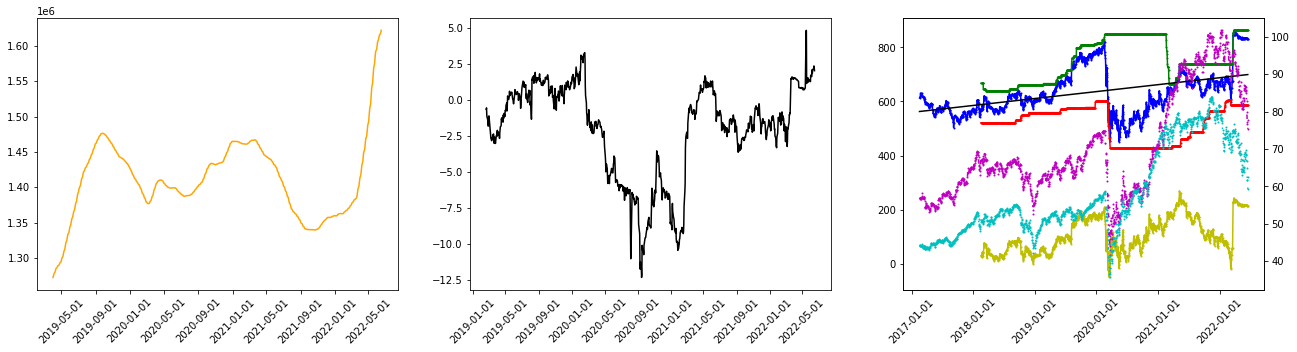

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 6246.773868881035 9811.844809032544
test cv mean error, stdev (10 folds): 6730.508643828475 10164.918844992177
sell date: 2022-08-07
expected return: 0.03259007271089594
discounted return: 0.0006290267650088666
quarter return: 1.0595584544910155


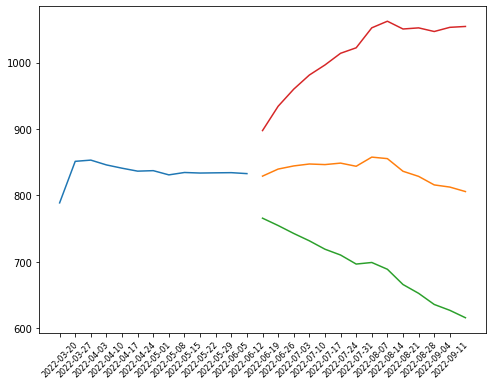

['options', ('2022-07-15',)]
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 8.71
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            11.77
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.71
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 30.32
peerGroup              Insurance
smallArms                  False
environmentScore            1.23
governancePercentile        None
militaryContract           F

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  206.449997  185.297076  198.254762  211.212449  190.815873   

             90dSDev   90d_lower   90d_upper  
2022-06-16  7.379416  176.057041  205.574705

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
SAFM      1.287362  206.449997  5064230.46875  0.962912  0.651375  0.476748

Sector 1YMF: -69.8699951171875
Sector Volume Factor: 1.4804916728676867
Sector Risk Trend Factor: -2.02874535900685
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


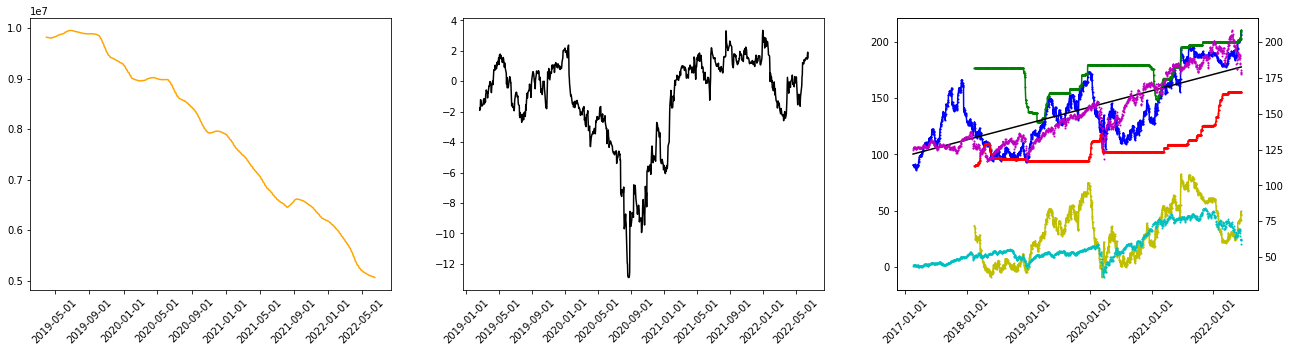

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 341.4043344769378 451.53600389174676
test cv mean error, stdev (10 folds): 369.6812742680705 464.19593120201364
sell date: 2022-07-10
expected return: 0.0447918232238952
discounted return: 0.0019069312480921585
quarter return: 1.1915686274019364


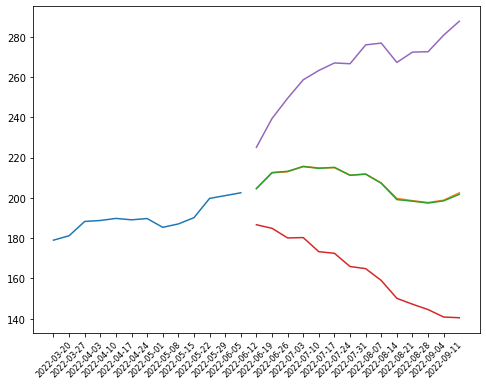

['options', ('2022-08-19', '2022-12-16')]
symbol: BANF
sector: Financial Services
Index: SP600
vol_30d_2yr: 2480129.6875
Sector 1YMF: 25.399993896484375
1YMF: 25.399993896484375
risk trend factor: 1.5227813808014614
          beta dividendRate dividendYield earningsGrowth ebitdaMargins  \
BANF  1.261764         1.44        0.0176          -0.15             0   

      forwardPE grossMargins grossProfits heldPercentInstitutions  \
BANF  25.541208            0    489579000                 0.46682   

            industry   marketCap operatingMargins payoutRatio pegRatio  \
BANF  Banks—Regional  3028237568          0.43254      0.2934     2.57   

     priceToBook priceToSalesTrailing12Months profitMargins revenueGrowth  \
BANF    2.640443                     6.197036       0.32952        -0.008   

     revenuePerShare              sector sharesOutstanding shortRatio  \
BANF          14.947  Financial Services          32572200       6.33   

       totalCash totalCashPerShare totalDebt 

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  91.559998  80.113243  89.27873  98.444217  85.368096  4.066924   

            90d_lower  90d_upper  
2022-06-16  77.234248  93.501943

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
BANF      1.077928  91.559998  2480129.6875  0.912771  0.918694  0.536414

Sector 1YMF: -73.55999755859375
Sector Volume Factor: 1.2176833027526361
Sector Risk Trend Factor: -3.976216084248311
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


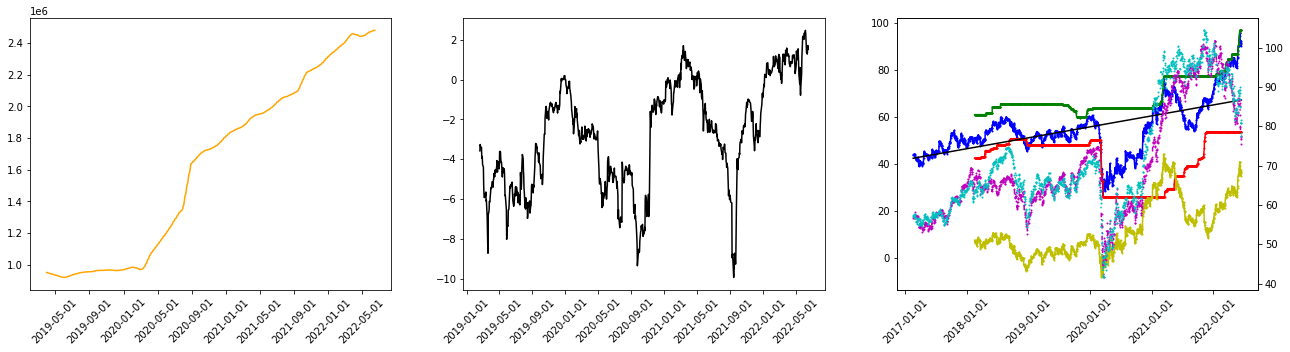

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 57.43070909139858 34.23390711310378
test cv mean error, stdev (10 folds): 60.476525300086834 34.454503767797306
sell date: 2022-09-18
expected return: 0.05141243020409907
discounted return: 0.0005392252421581034
quarter return: 1.050845787629788


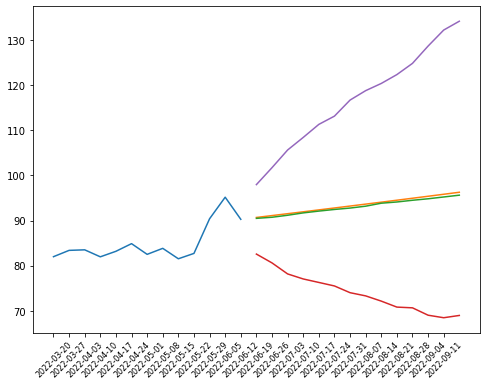

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Total Stockholder Equity          1.171734e+09  1.171734e+09  1.146874e+09   
Net Tangible Assets               1.004246e+09  1.004246e+09  9.786270e+08   
Intangible Assets                          NaN  1.756600e+07  1.832500e+07   
Capital Surplus                            NaN  1.599140e+08  1.588770e+08   
Total Liab                                 NaN  8.233878e+09  1.015590e+10   
Total Assets                               NaN  9.405612e+09  1.130277e+10   
Common Stock                               NaN  3.260300e+07  3.257200e+07   
Other Current Assets                       NaN  4.577600e+07  4.215000e+07   
Retained Earnings                          NaN  9.770670e+08  9.505600e+08   
Good Will                                  NaN  1.499220e+08  1.499220e+08   
Treasury Stock                             NaN  2.150000e+06  4.865000e+06   
Other Assets                        

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     35.09  26.840788  35.541111  44.241434  29.769206  5.452506   

            90d_lower  90d_upper  
2022-06-16  18.864194  40.674218

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PBF      0.768095    35.09  92708582.421875  0.774588  0.622395  0.555912

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


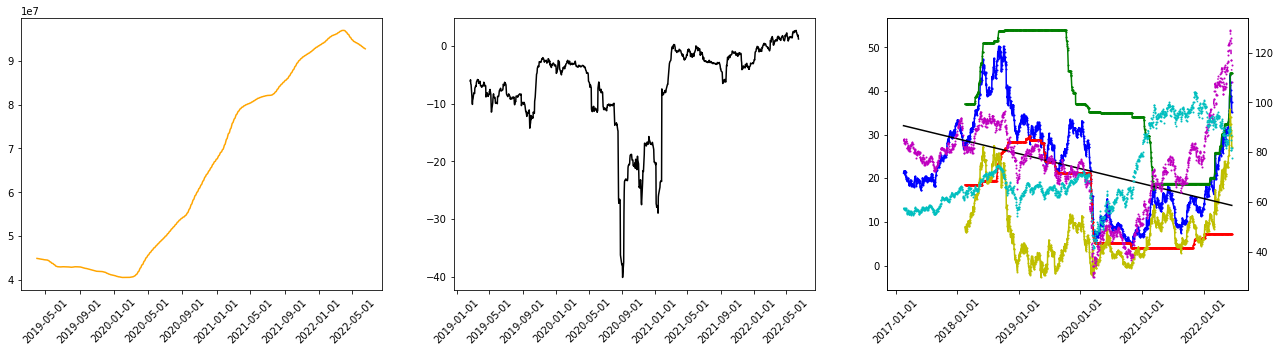

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 25.720877012049698 17.863936823666034
test cv mean error, stdev (10 folds): 22.973989066046546 16.371710054407494
sell date: 2022-09-18
expected return: 0.4470970920208785
discounted return: 0.003981664387167294
quarter return: 1.4413580878533077


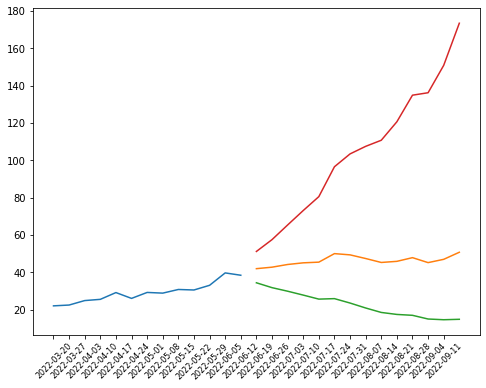

['options', ('2022-06-17', '2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: TWI
sector: Industrials
Index: SP600
vol_30d_2yr: 10535892.7734375
Sector 1YMF: 7.760000228881836
1YMF: 7.760000228881836
risk trend factor: 1.1883614925281147
         beta currentRatio debtToEquity earningsGrowth     ebitda  \
TWI  2.412885        1.853      219.119          0.682  163579008   

    ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
TWI       0.08464   8.09589    -24455124      0.13457    227051000   

    heldPercentInstitutions                             industry   marketCap  \
TWI                 0.77816  Farm & Heavy Construction Machinery  1110906752   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
TWI           8171000          0.06043           0     0.38    4.470499   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
TWI                     0.574797       0.03101      0.829        0.06237   

   

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     18.08  16.262576  18.084127  19.905678  15.902698  1.926426   

            90d_lower 90d_upper  
2022-06-16  12.049847  19.75555

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TWI      1.294157    18.08  10535892.773438  0.906939  0.834351  0.500331

Sector 1YMF: -141.6699981689453
Sector Volume Factor: 0.8731518814579678
Sector Risk Trend Factor: -4.0477142333984375
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


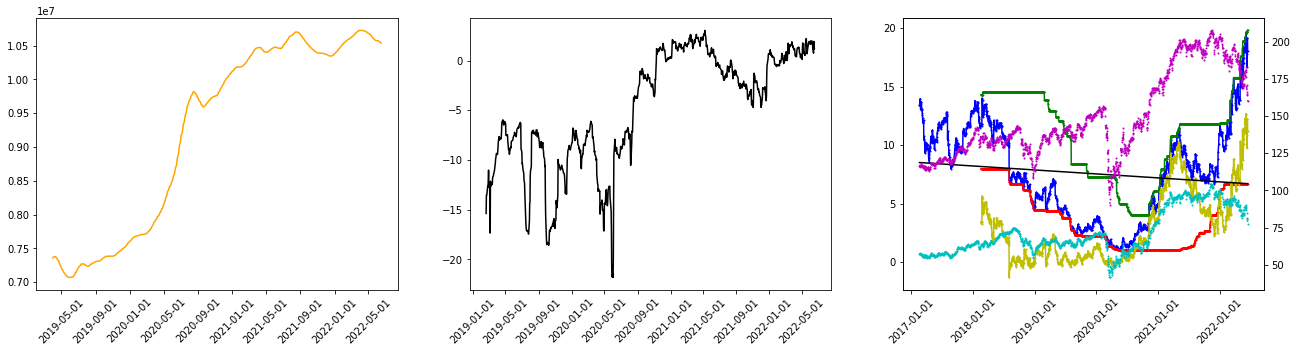

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 4.563758803723551 7.424541486283341
test cv mean error, stdev (10 folds): 5.008942337795256 7.64566181594025
sell date: 2022-07-10
expected return: 0.1656193565138642
discounted return: 0.006685403958885949
quarter return: 1.8459800501751473


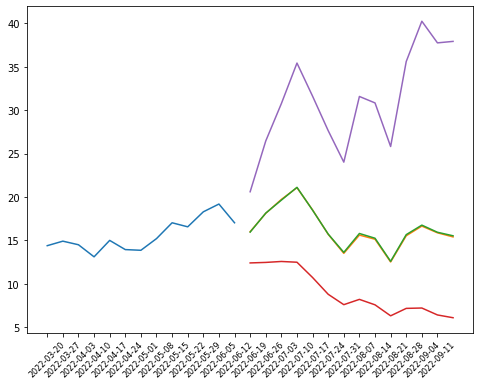

['options', ('2022-07-15',)]
symbol: CEIX
sector: Energy
Index: SP600
vol_30d_2yr: 10281161.1328125
Sector 1YMF: 22.600006103515625
1YMF: 22.600006103515625
risk trend factor: 1.1035159476887273
          beta currentRatio debtToEquity earningsGrowth     ebitda  \
CEIX  2.379059        0.868      100.167          5.642  282313984   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CEIX       0.22235  9.169261    196007120      0.33279    422536000   

     heldPercentInstitutions      industry   marketCap operatingCashflow  \
CEIX                 0.86884  Thermal Coal  1625051904         305568992   

     operatingMargins payoutRatio priceToBook priceToSalesTrailing12Months  \
CEIX          0.04547           0    3.353494                     1.279876   

     profitMargins quickRatio returnOnAssets returnOnEquity revenueGrowth  \
CEIX       0.02686      0.586        0.01416        0.05563         0.249   

     revenuePerShare  sector sharesOutstanding shortRati

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-16  49.060001  48.004985  52.513302  57.021619  46.495238  6.61632   

            90d_lower  90d_upper  
2022-06-16  33.262598  59.727878

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
CEIX      1.464659  49.060001  10281161.132812  0.814788  0.891799  0.522582

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


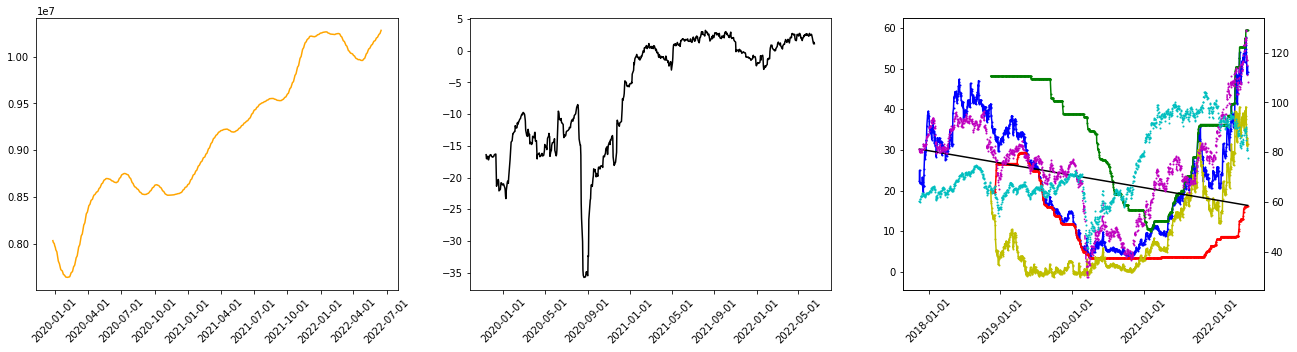

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 36.97631528473198 64.10181216623809
test cv mean error, stdev (10 folds): 36.97631528473198 64.10181216623809
sell date: 2022-09-04
expected return: 0.5429120382517398
discounted return: 0.005504608466211591
quarter return: 1.6570439136742172


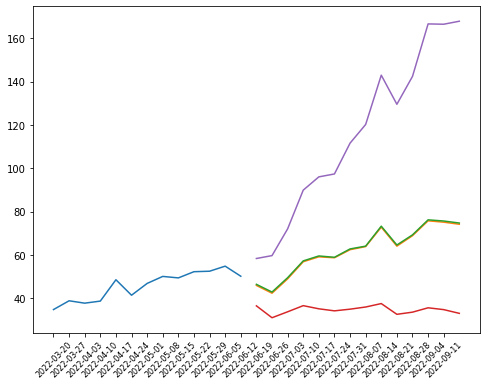

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   6.469450e+08  6.449200e+08  6.430330e+08   
Total Liab                        1.900704e+09  2.105167e+09  1.965198e+09   
Total Stockholder Equity          6.728130e+08  4.845800e+08  5.927330e+08   
Other Current Liab                1.790310e+08  2.688430e+08  1.451780e+08   
Total Assets                      2.573517e+09  2.589747e+09  2.557931e+09   
Common Stock                      3.450000e+05  3.450000e+05  3.450000e+05   
Other Current Assets              3.747200e+07  4.242800e+07  3.166900e+07   
Retained Earnings                 2.809600e+08  1.636370e+08  2.774260e+08   
Other Liab                        8.455480e+08  9.379920e+08  9.285180e+08   
Treasury Stock                   -2.554370e+08 -3.243220e+08 -3.280710e+08   
Other Assets                      5.153480e+08  5.008660e+08  4.742010e+08   
Cash                              1.

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  59.540001  59.091792  66.38219  73.672588  61.651587  5.304665   

            90d_lower  90d_upper  
2022-06-16  51.042258  72.260917

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
LNTH      1.772745  59.540001  14113253.515625  0.774897  0.957446  0.533091

Sector 1YMF: -124.31001281738281
Sector Volume Factor: 1.2144136602789217
Sector Risk Trend Factor: -2.8504922628415557
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


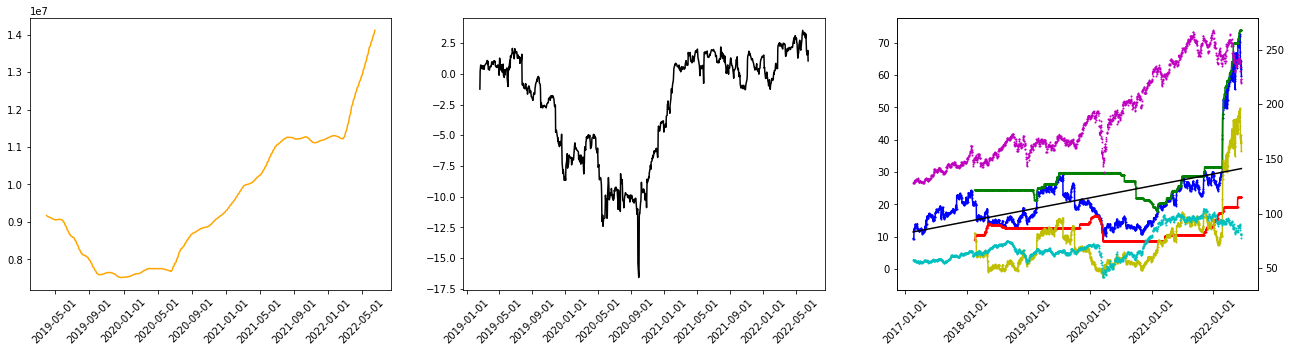

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 41.48282594748043 60.16277129292424
test cv mean error, stdev (10 folds): 42.472503998805934 63.01381599971796
sell date: 2022-09-18
expected return: 0.08386712325682995
discounted return: 0.0008663461954796503
quarter return: 1.0829289318966995


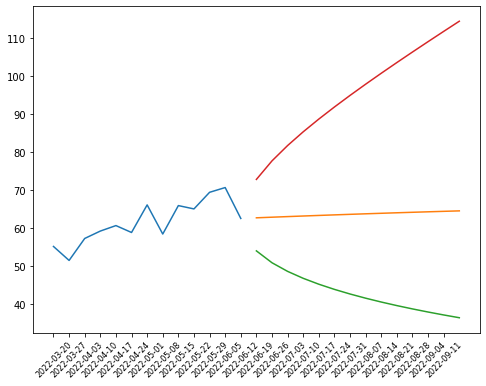

['quarterly_balance_sheet',                                    2022-03-31   2021-12-31   2021-09-30  \
Intangible Assets                 340204000.0  348510000.0  356883000.0   
Capital Surplus                   691516000.0  685472000.0  680819000.0   
Total Liab                        417316000.0  399345000.0  348472000.0   
Total Stockholder Equity          515850000.0  464439000.0  499344000.0   
Other Current Liab                 89178000.0          NaN          NaN   
Total Assets                      933166000.0  863784000.0  847816000.0   
Common Stock                         686000.0     677000.0     677000.0   
Other Current Assets               12860000.0    2705000.0   12043000.0   
Retained Earnings                -178263000.0 -221225000.0 -181010000.0   
Other Liab                         64083000.0  129181000.0   88437000.0   
Good Will                          61189000.0   61189000.0   61189000.0   
Treasury Stock                      1911000.0    -485000.0   -1142000.0 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  40.450001  35.617662  37.784079  39.950497  35.093175  2.395336   

            90d_lower  90d_upper  
2022-06-16  30.302502  39.883847

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
GO      1.107204  40.450001  21743692.96875  0.697775  0.177952  0.402887

Sector 1YMF: -69.8699951171875
Sector Volume Factor: 1.4804916728676867
Sector Risk Trend Factor: -2.02874535900685
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


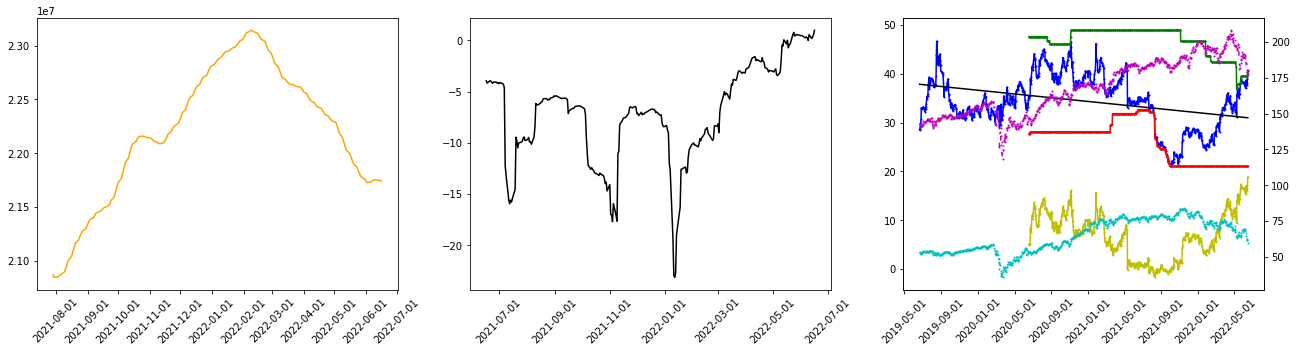

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 15.80987933983161 6.829165054824745
test cv mean error, stdev (10 folds): 15.809879339831612 6.829165054824745
sell date: 2022-07-24
expected return: 0.014618691441191397
discounted return: 0.00039231662398697686
quarter return: 1.0367450559027056


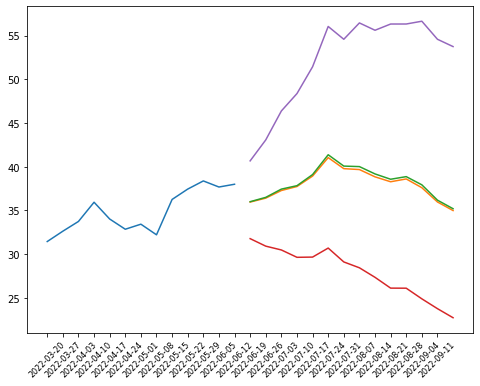

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: XOM
sector: error
sector: error
Index: SP500
vol_30d_2yr: 552368724.0234375
Sector 1YMF: 24.93999481201172
1YMF: 24.93999481201172
risk trend factor: 0.9490105011595055
Empty DataFrame
Columns: []
Index: [XOM]


Adj Close    21dBOLD   21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-16  91.389999  89.198012  96.716825  104.235638  88.786289  6.588575   

            90d_lower   90d_upper  
2022-06-16  75.609139  101.963438

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
XOM      1.083511  91.389999  552368724.023438  0.809562  0.916245  0.534339

Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


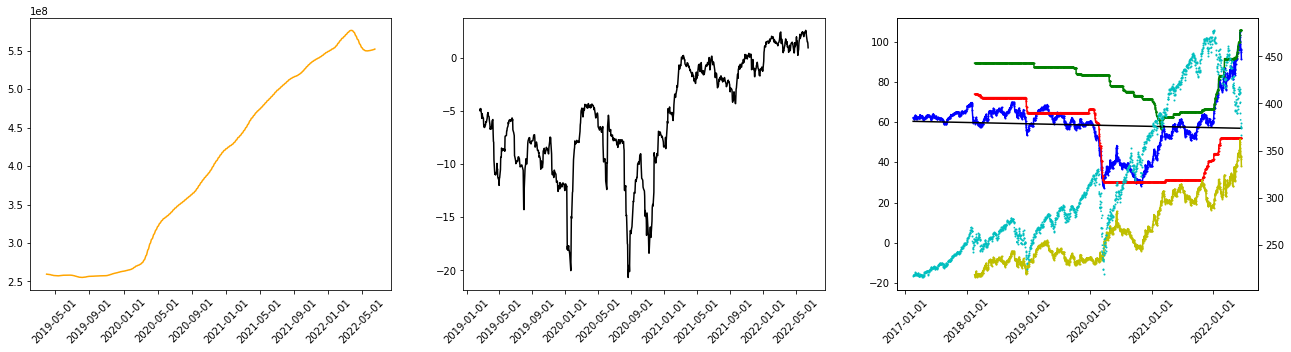

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 97.73490803510009 107.32363912819847
test cv mean error, stdev (10 folds): 107.20989594386506 108.08678833916397
sell date: 2022-09-18
expected return: 0.23531371659580935
discounted return: 0.0022748950470505847
quarter return: 1.2325098859607904


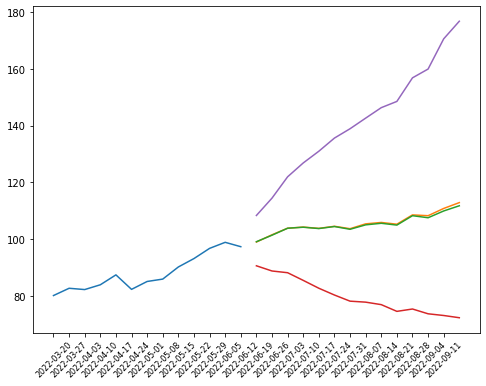

['mutualfund_holders',                                                Holder     Shares  \
0              Vanguard Total Stock Market Index Fund  120310714   
1              Vanguard Total Stock Market Index Fund  120310714   
2               Select Sector SPDR Fund-Energy Select  104790890   
3               Select Sector SPDR Fund-Energy Select  104790890   
4                             Vanguard 500 Index Fund   89656123   
5                             Vanguard 500 Index Fund   89656123   
6                              SPDR S&P 500 ETF Trust   44986060   
7                              SPDR S&P 500 ETF Trust   44986060   
8                             Fidelity 500 Index Fund   43355092   
9                             Fidelity 500 Index Fund   43355092   
10                           iShares Core S&P 500 ETF   35205800   
11                           iShares Core S&P 500 ETF   35205800   
12                    Vanguard Index-Value Index Fund   32349611   
13                    Van

Adj Close     21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-16  304.019989  301.863634  319.558729  337.253824  317.76984   

              90dSDev   90d_lower   90d_upper  
2022-06-16  10.161133  297.447575  338.092106

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MCK      0.981008  304.019989  22892569.726562  0.820561  0.997806  0.461676

Sector 1YMF: -124.31001281738281
Sector Volume Factor: 1.2144136602789217
Sector Risk Trend Factor: -2.8504922628415557
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


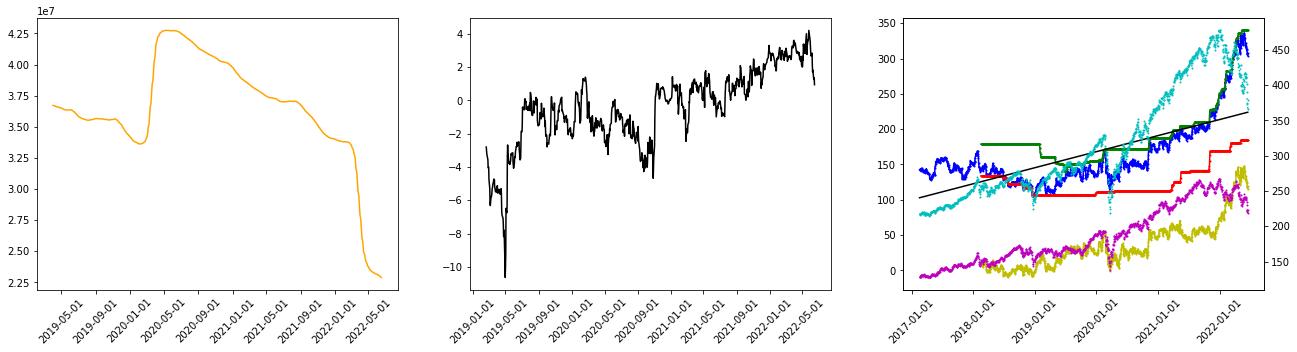

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 460.68525262037815 633.1761312071055
test cv mean error, stdev (10 folds): 495.9381907679 653.7069393524685
sell date: 2022-09-04
expected return: 0.06365637617324695
discounted return: 0.0007814746104450876
quarter return: 1.074513054576828


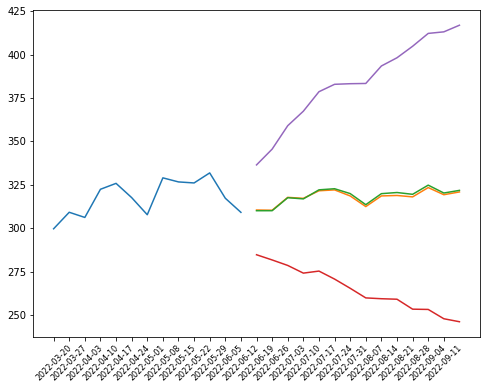

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                             Value
2022-5                           
palmOil                     False
controversialWeapons        False
gambling                    False
socialScore                  7.37
nuclear                     False
furLeather                  False
alcoholic                   False
gmo                         False
catholic                    False
socialPercentile                0
peerCount                      58
governanceScore              5.52
environmentPercentile           0
animalTesting               False
tobacco                     False
totalEsg                    15.17
highestControversy              3
esgPerformance           LAG_PERF
coal                        False
pesticides                  False
adult                       False
percentile                  10.18
peerGroup              Healthcare
smallArms                   False
environmentScore             2.29
governa

Adj Close   21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  102.419998  101.7508  112.619206  123.487613  104.448413   

             90dSDev  90d_lower   90d_upper  
2022-06-16  7.348641  89.751132  119.145694

volume_factor    latest_p       vol_30d_2yr  pct_2yr       adf    hurst
COP        0.8692  102.419998  189223264.453125  0.77566  0.929388  0.48705

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


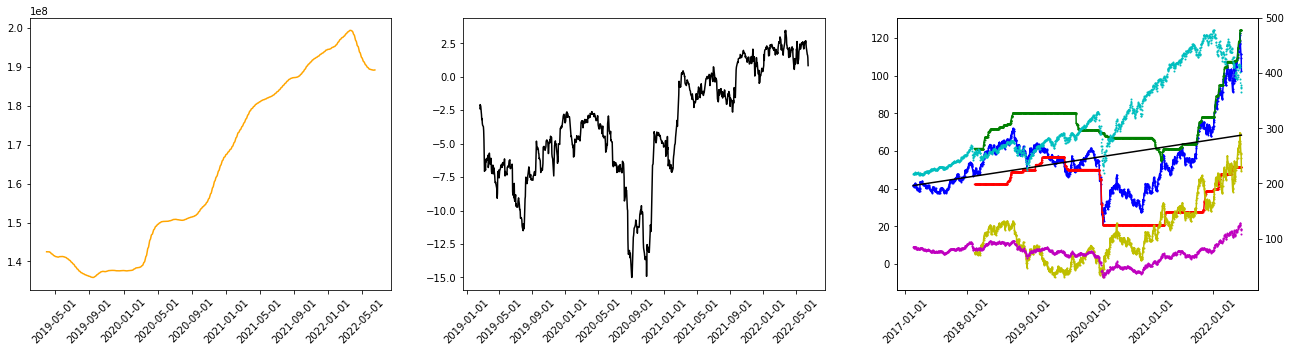

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 143.25760529439555 169.46635721089507
test cv mean error, stdev (10 folds): 156.83364486058147 171.94040477575322
sell date: 2022-09-18
expected return: 0.23531551862796574
discounted return: 0.002274910768365501
quarter return: 1.2325116645701102


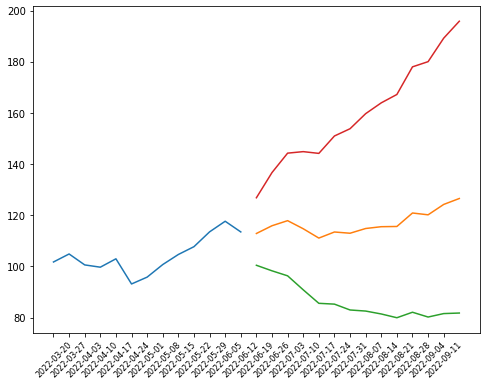

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            6.058100e+10  6.043100e+10  6.033700e+10   
Total Liab                 4.525500e+10  4.318900e+10  4.112700e+10   
Total Stockholder Equity   4.540600e+10  4.411500e+10  4.427600e+10   
Other Current Liab         4.390000e+09  3.763000e+09  2.094000e+09   
Total Assets               9.066100e+10  8.730400e+10  8.540300e+10   
Common Stock               2.100000e+07  2.100000e+07  2.100000e+07   
Other Current Assets       1.348000e+09  1.696000e+09  7.800000e+08   
Retained Earnings          4.067400e+10  3.830700e+10  3.711600e+10   
Other Liab                 1.402100e+10  1.399200e+10  1.417200e+10   
Treasury Stock            -5.587000e+10 -5.464400e+10 -5.319800e+10   
Other Assets               2.036000e+09  2.376000e+09  2.501000e+09   
Cash                       5.028000e+09  9.833000e+09  6.608000e+09   
Total Current Liabilities  1.202100e+10  1.044900

Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-16     33.27  32.463712  34.639683  36.815653  29.59127  4.038276   

            90d_lower  90d_upper  
2022-06-16  21.514719  37.667821

volume_factor latest_p      vol_30d_2yr   pct_2yr      adf     hurst
HRB      1.002949    33.27  54246410.742188  0.850294  0.68658  0.435784

Sector 1YMF: -369.34999084472656
Sector Volume Factor: 1.2963402483527684
Sector Risk Trend Factor: -4.1537329629948685
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


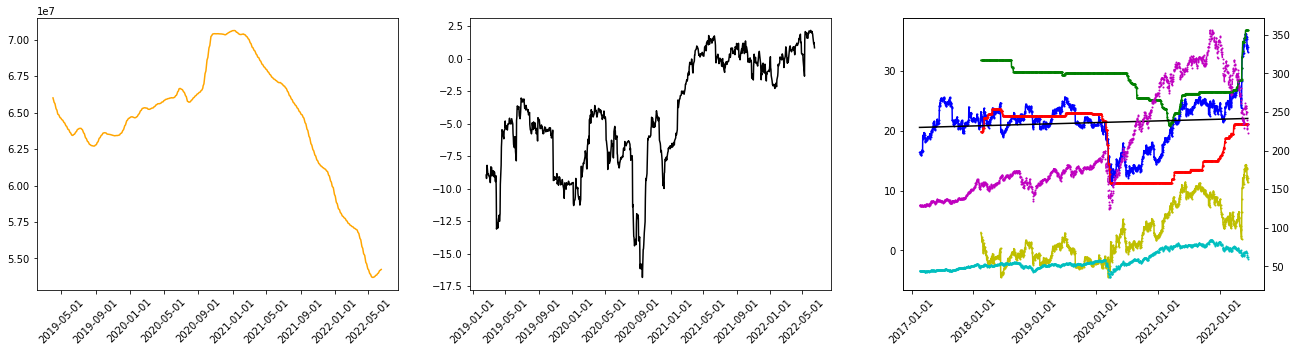

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 7.876975207816215 7.1666374330399965
test cv mean error, stdev (10 folds): 8.085382812116858 7.484583508127284
sell date: 2022-08-07
expected return: 0.07922483240376207
discounted return: 0.0014960794954594903
quarter return: 1.1474435369623213


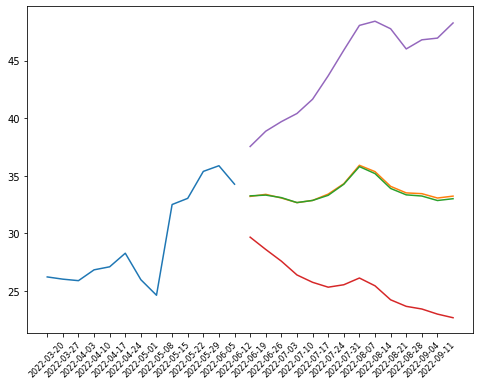

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-04-30  \
Intangible Assets                 3.345570e+08  3.374510e+08  3.601480e+08   
Capital Surplus                   7.706610e+08  7.706830e+08  7.832920e+08   
Total Liab                        3.472710e+09  3.352499e+09  3.301245e+09   
Total Stockholder Equity         -3.726550e+08  1.552800e+07  3.524010e+08   
Other Current Liab                2.636960e+08  3.421690e+08  4.931200e+08   
Total Assets                      3.100055e+09  3.368027e+09  3.653646e+09   
Common Stock                      2.033000e+06  2.099000e+06  2.167000e+06   
Other Current Assets              1.236860e+08  1.390670e+08  1.286690e+08   
Retained Earnings                -4.668560e+08 -7.475700e+07  2.485060e+08   
Other Liab                        3.246140e+08  3.938340e+08  4.055010e+08   
Good Will                         7.591830e+08  7.494090e+08  7.576590e+08   
Treasury Stock                   -6.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  43.299999  35.804937  46.433175  57.061412  41.064762  5.410478   

            90d_lower  90d_upper  
2022-06-16  30.243807  51.885717

volume_factor   latest_p  vol_30d_2yr   pct_2yr       adf     hurst
SM      0.613435  43.299999  85523868.75  0.782398  0.889778  0.475064

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


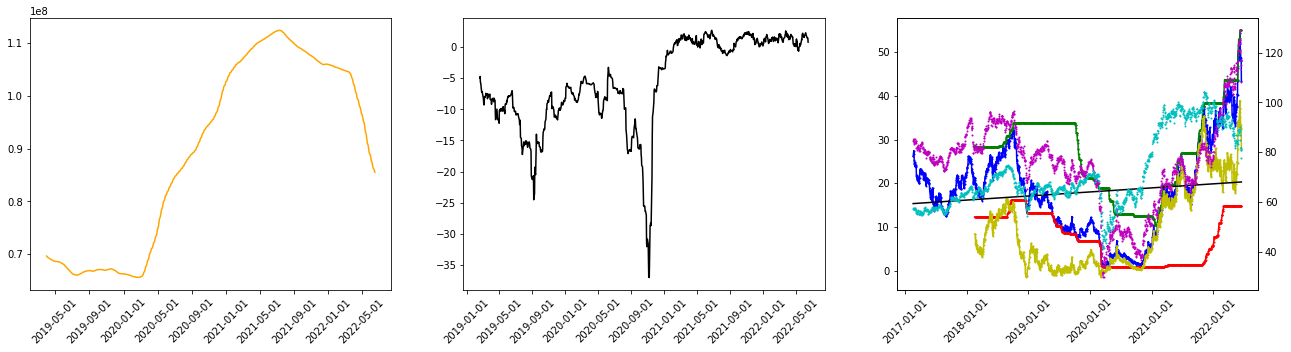

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 63.929367331236 97.81975162654231
test cv mean error, stdev (10 folds): 70.16542781018352 100.48781635520929
sell date: 2022-06-19
expected return: 0.13118389304907963
discounted return: 0.06357129194477595
quarter return: 290.0866736776227


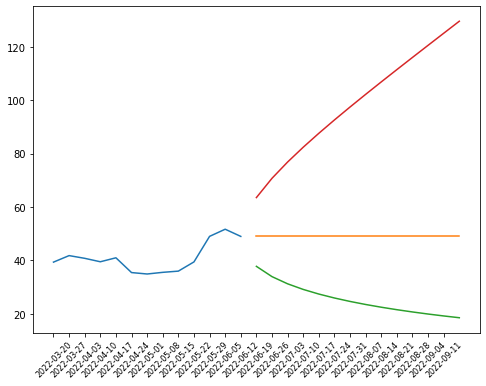

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
symbol: DVN
sector: Energy
Index: SP500
vol_30d_2yr: 237831403.90625
Sector 1YMF: 20.21000099182129
1YMF: 20.21000099182129
risk trend factor: 0.7690258370233172
         beta currentRatio debtToEquity dividendRate dividendYield  \
DVN  2.588475        1.325       71.489         5.08        0.0742   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
DVN          3.625  6653000192        0.4454  6.462943   3098249984   

    grossMargins grossProfits heldPercentInstitutions       industry  \
DVN      0.58211   7414000000                 0.84985  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
DVN  39712198656        6144000000          0.29732      0.4991     0.35   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
DVN    4.274652                     2.658646       0.24027      1.188   

    returnOnAssets returnOnEquity revenueGrowth reven

Adj Close 21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     63.27  65.653  73.105238  80.557476  65.763333  6.439721   

            90d_lower  90d_upper  
2022-06-16  52.883892  78.642775

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
DVN      1.026625    63.27  237831403.90625  0.774941  0.955415  0.547561

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


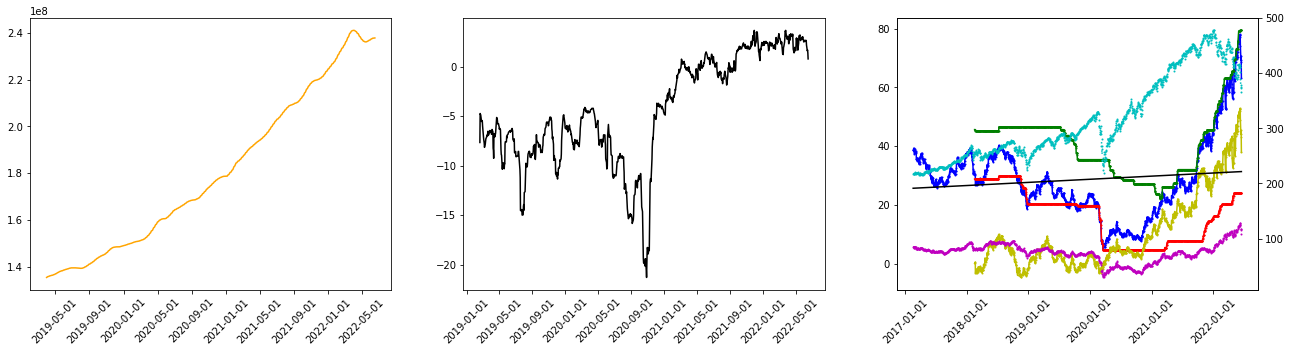

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 83.12660658892773 137.91142109736185
test cv mean error, stdev (10 folds): 90.96221672637152 142.28897168629175
sell date: 2022-09-18
expected return: 0.797646234364674
discounted return: 0.006326142840587856
quarter return: 1.786345557207148


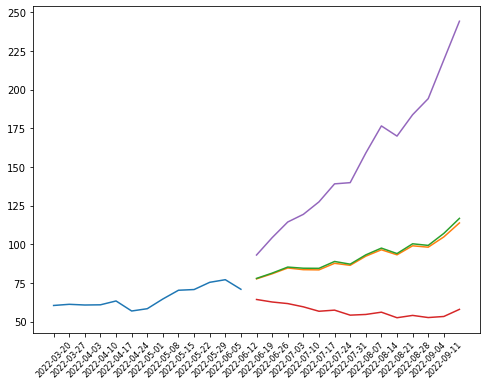

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.78
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.86
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             34.39
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  257.079987  254.024813  260.133967  266.243121  267.796825   

             90dSDev   90d_lower   90d_upper  
2022-06-16  6.249567  255.297691  280.295958

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
ROG      0.994011  257.079987  3248152.734375  0.902528  0.707598  0.478685

Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


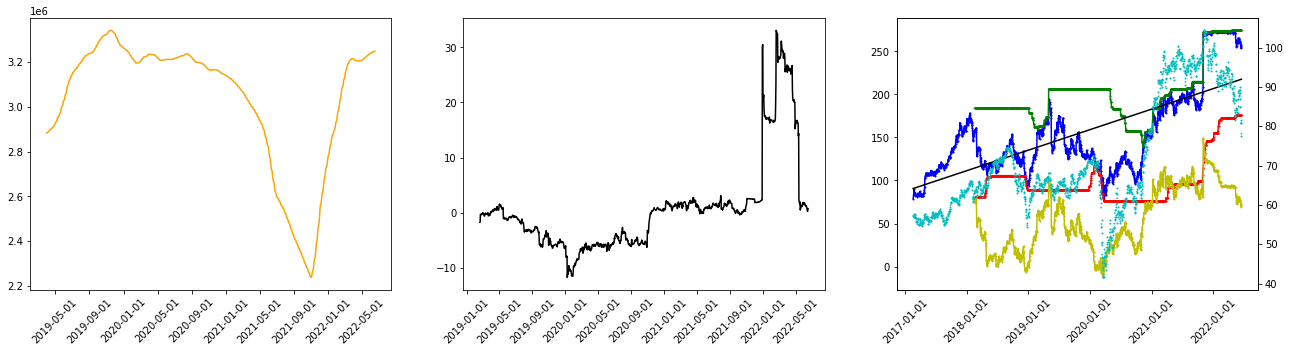

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 850.4186272902851 1192.0450461734074
test cv mean error, stdev (10 folds): 929.9643875509277 1222.0743546869942
sell date: 2022-06-19
expected return: -0.0017051801509878077
discounted return: -0.0008529538406210069
quarter return: 0.9244972166894726


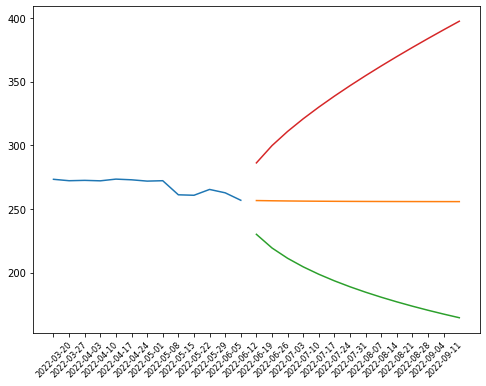

['options', ('2022-06-17',)]
symbol: SJI
sector: error
sector: error
Index: SP600
vol_30d_2yr: 26835210.15625
Sector 1YMF: 1.3999958038330078
1YMF: 1.3999958038330078
risk trend factor: 0.6666639418858753
Empty DataFrame
Columns: []
Index: [SJI]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  33.759998  33.569809  34.296825  35.023842  34.249841  0.377921   

           90d_lower  90d_upper  
2022-06-16    33.494  35.005683

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
SJI      0.714807  33.759998  26835210.15625  0.908665  0.156179  0.415159

Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


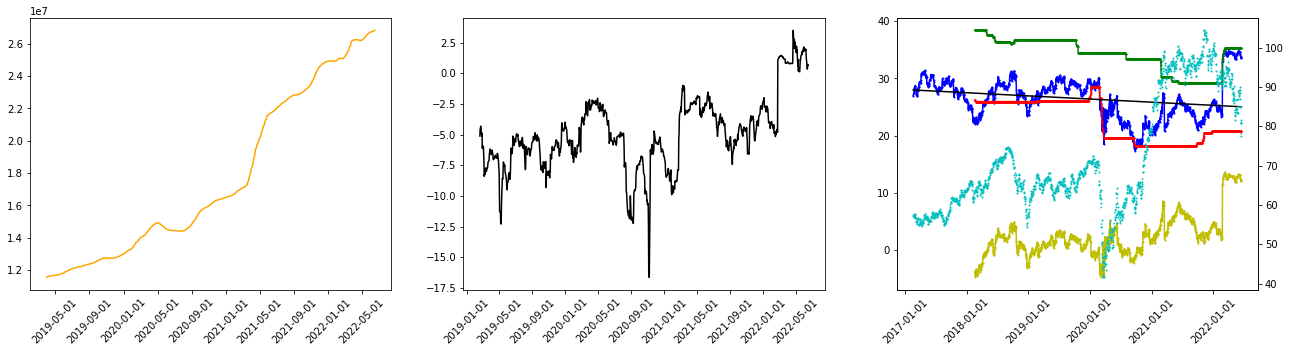

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 8.57891461718493 6.743172921267984
test cv mean error, stdev (10 folds): 9.098370749065896 6.859244780807526
sell date: 2022-09-18
expected return: 0.05609237205772791
discounted return: 0.0005870072213238764
quarter return: 1.055472801901096


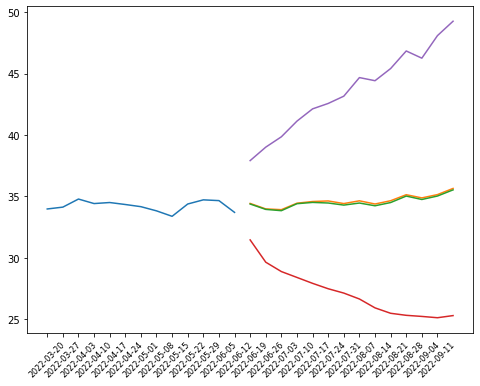

['options', ('2022-07-15',)]
symbol: APA
sector: Energy
Index: SP500
vol_30d_2yr: 204947064.2578125
Sector 1YMF: 10.489994049072266
1YMF: 10.489994049072266
risk trend factor: 0.6626653718064264
         beta currentRatio debtToEquity dividendRate dividendYield  \
APA  4.125226        1.227      704.108          0.5         0.012   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
APA          4.324  4982000128       0.56569  4.022178   2424875008   

    grossMargins grossProfits heldPercentInstitutions       industry  \
APA      0.67015   5080000000                 0.86629  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
APA  13495457792        3716000000          0.40218      0.0339     0.17   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
APA                     1.532356       0.28023      0.882        0.17293   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstan

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-16  41.759998  40.031775  46.123016  52.214257  42.944286  3.29672   

            90d_lower  90d_upper  
2022-06-16  36.350846  49.537726

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
APA      0.960568  41.759998  204947064.257812  0.771011  0.332977  0.446771

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


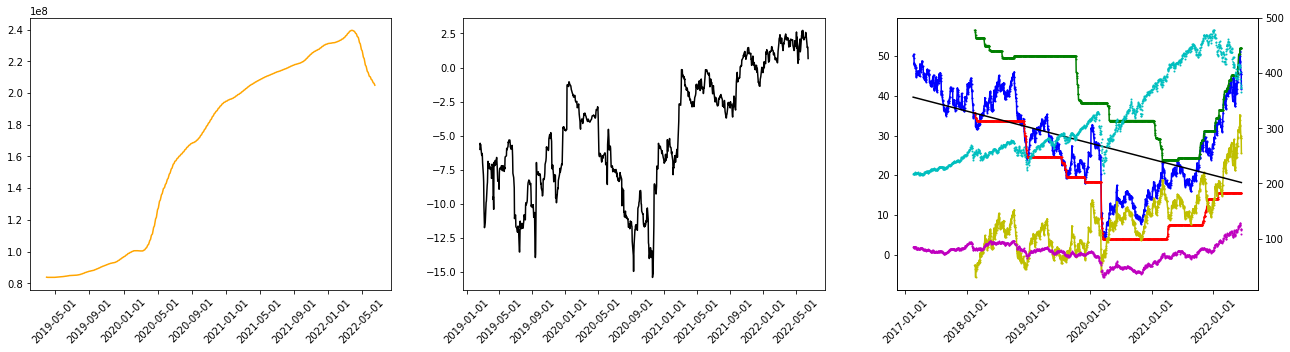

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 36.85290742437288 39.68174022446753
test cv mean error, stdev (10 folds): 40.3098803558175 40.00809135666297
sell date: 2022-07-03
expected return: 0.288656410404112
discounted return: 0.01597628599654799
quarter return: 4.298219066376698


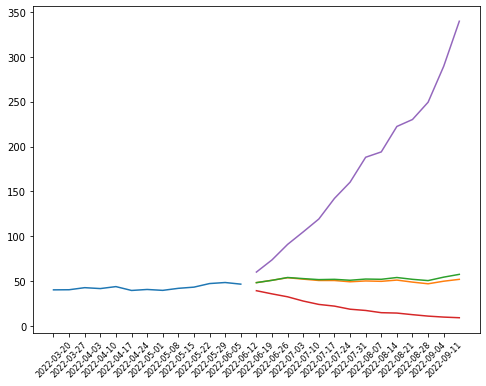

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2021-3                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.88
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               71
governanceScore                       7.96
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             38.81
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD    21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-16  91.980003  91.102268  102.463968  113.825668  92.242475  8.974023   

           90d_lower   90d_upper  
2022-06-16  74.29443  110.190521

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
MPC      1.076525  91.980003  141887166.210938  0.745187  0.710335  0.51907

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


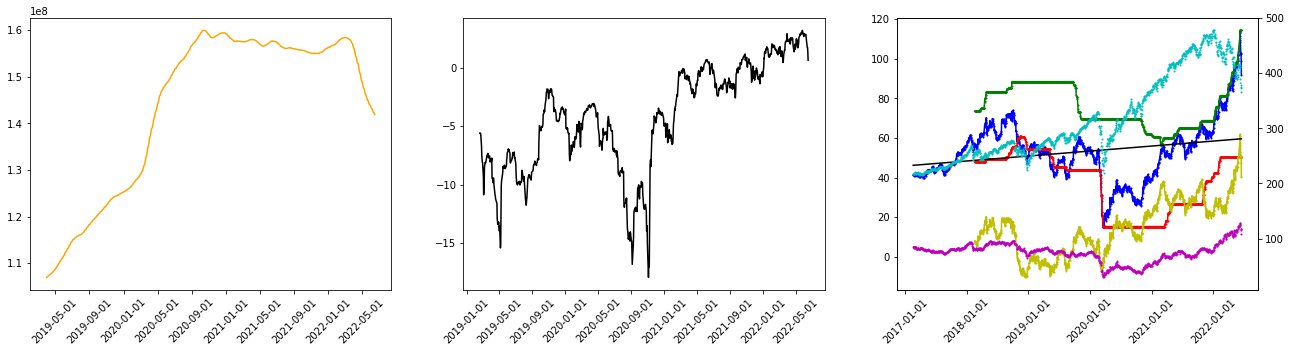

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 131.0795318352937 179.9759321483381
test cv mean error, stdev (10 folds): 136.70941679332753 187.83455254633932
sell date: 2022-08-28
expected return: 0.2450897103588813
discounted return: 0.003049189124186169
quarter return: 1.323260252034655


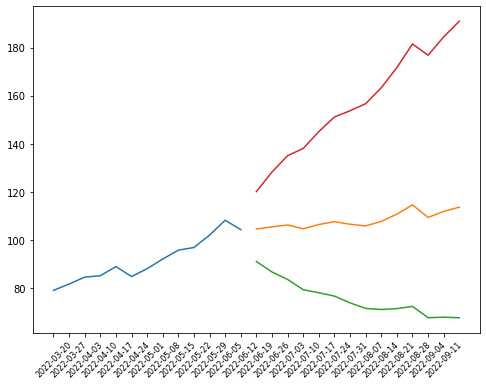

['options', ('2022-07-15', '2022-09-16', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.01
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        5.87
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              28.78
highestControversy                        3
esgPerformance                     AVG_PERF
coal                           

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     47.77  43.583972  51.079524  58.575075  43.652222  6.256969   

            90d_lower  90d_upper  
2022-06-16  31.138285  56.166159

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
DINO      1.003531    47.77  51415267.1875  0.742624  0.504978  0.561898

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


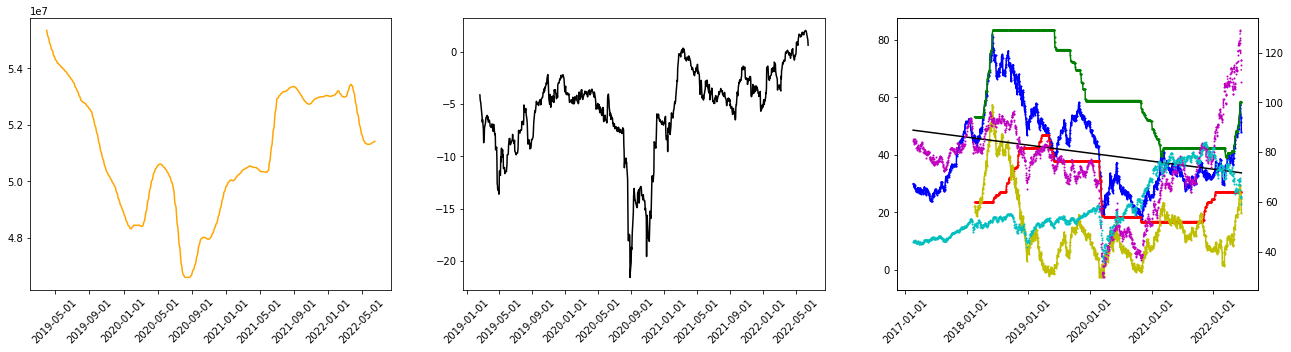

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 72.576460284287 85.73941116506437
test cv mean error, stdev (10 folds): 78.90488809801519 87.44049172644745
sell date: 2022-09-18
expected return: 0.4346881252397488
discounted return: 0.003888697258628948
quarter return: 1.4291306687260636


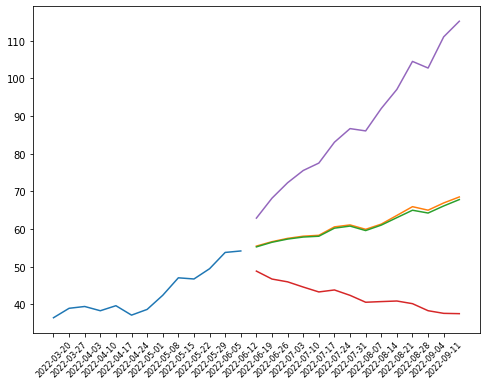

symbol: MRO
sector: Energy
Index: SP500
vol_30d_2yr: 490913172.265625
Sector 1YMF: 6.459999084472656
1YMF: 6.459999084472656
risk trend factor: 0.6217515185815937
         beta currentRatio debtToEquity dividendRate dividendYield  \
MRO  2.570326        1.103       36.547         0.32        0.0114   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
MRO         13.833  3833999872       0.61789  5.767605   1898625024   

    grossMargins grossProfits heldPercentInstitutions       industry  \
MRO      0.78646   4355000000                 0.80251  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
MRO  17387968512        3684000000          0.28316      0.0769     0.54   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
MRO    1.549962                     2.802251       0.34698      1.051   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
MRO        0.06065         0.1954

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16     25.66  25.772469  29.609365  33.446261  26.939592  2.398748   

            90d_lower  90d_upper  
2022-06-16  22.142097  31.737087

volume_factor latest_p       vol_30d_2yr   pct_2yr       adf     hurst
MRO      0.917749    25.66  490913172.265625  0.743138  0.862619  0.540113

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


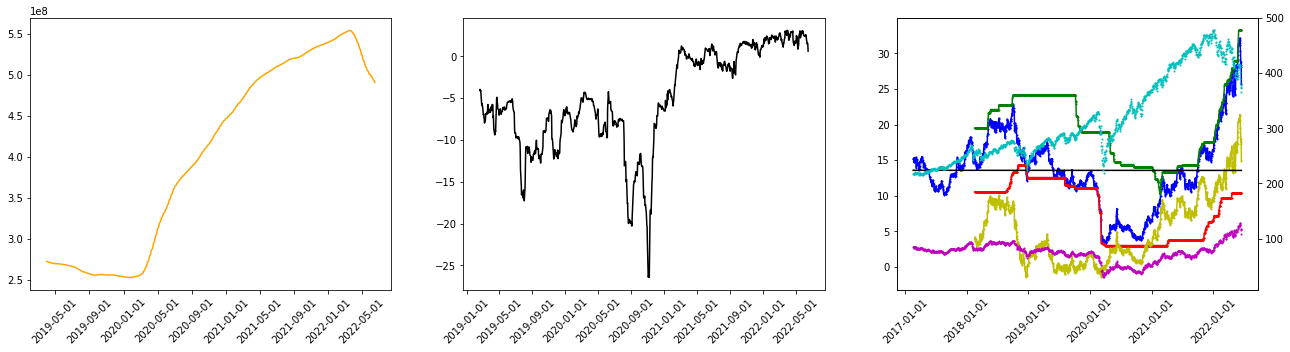

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 12.255532988040612 17.95164962742751
test cv mean error, stdev (10 folds): 13.299976731493661 18.506446200693375
sell date: 2022-09-18
expected return: 0.304604780251799
discounted return: 0.002863232581788777
quarter return: 1.3008800580845001


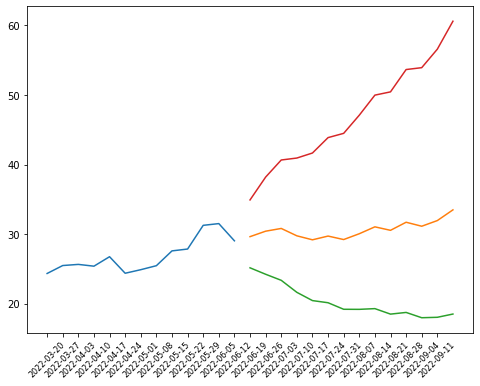

['options', ('2022-07-15', '2022-09-16', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          10.01
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.13
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             42.05
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticid

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  56.040001  48.109737  59.192857  70.275978  55.063175  5.230673   

            90d_lower  90d_upper  
2022-06-16  44.601828  65.524522

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MTDR      0.642698  56.040001  48834102.929688  0.809075  0.921632  0.464965

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


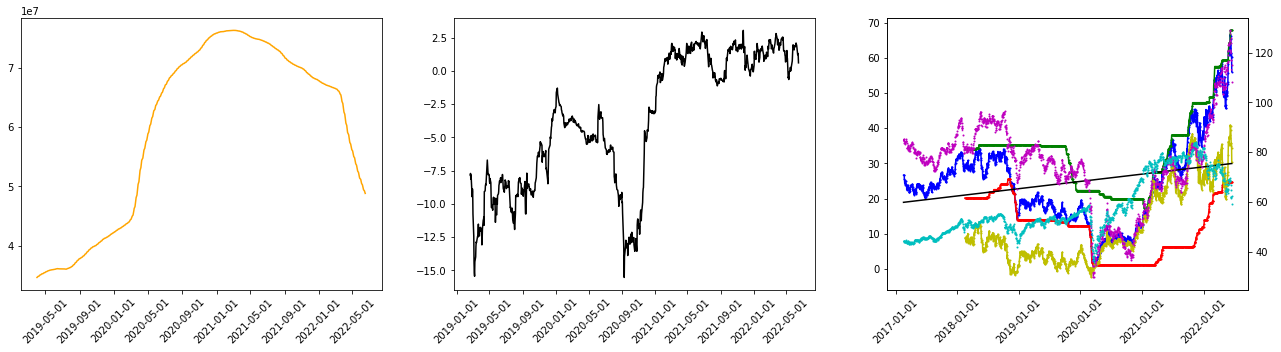

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 57.85716415916249 62.82249472903784
test cv mean error, stdev (10 folds): 63.3976024234568 63.27460239490576
sell date: 2022-09-18
expected return: 0.23860812589271907
discounted return: 0.002303598355273051
quarter return: 1.235761427899895


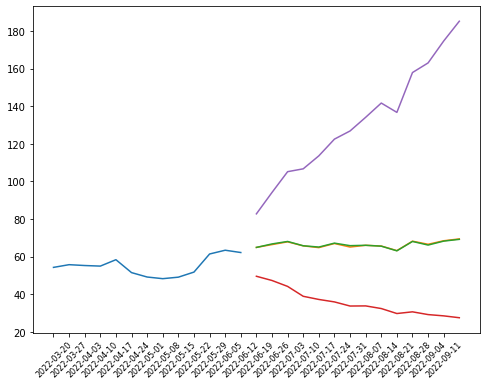

['options', ('2022-06-17', '2022-07-15', '2023-01-20')]
symbol: ROCC
sector: Energy
Index: SP600
vol_30d_2yr: 12003625.0
Sector 1YMF: 14.429996490478516
1YMF: 14.429996490478516
risk trend factor: 0.6123746319405766
          beta currentRatio debtToEquity     ebitda ebitdaMargins forwardPE  \
ROCC  2.866152        0.497       80.978  323780000       0.45632  4.088889   

     freeCashflow grossMargins grossProfits heldPercentInstitutions  \
ROCC    111158752       0.9232    508729000                 0.83063   

           industry   marketCap operatingCashflow operatingMargins  \
ROCC  Oil & Gas E&P  1051397696         390172992          0.23271   

     payoutRatio pegRatio priceToBook priceToSalesTrailing12Months  \
ROCC           0     0.14    3.345455                       1.4818   

     profitMargins quickRatio returnOnAssets returnOnEquity revenueGrowth  \
ROCC       0.06175      0.404        0.08139        0.19205         1.903   

     revenuePerShare  sector sharesOutstandin

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  41.779999  31.141411  43.043286  54.945161  37.837937  5.399882   

            90d_lower  90d_upper  
2022-06-16  27.038173  48.637701

volume_factor   latest_p vol_30d_2yr   pct_2yr       adf     hurst
ROCC      1.057805  41.779999  12003625.0  0.749947  0.601456  0.578912

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


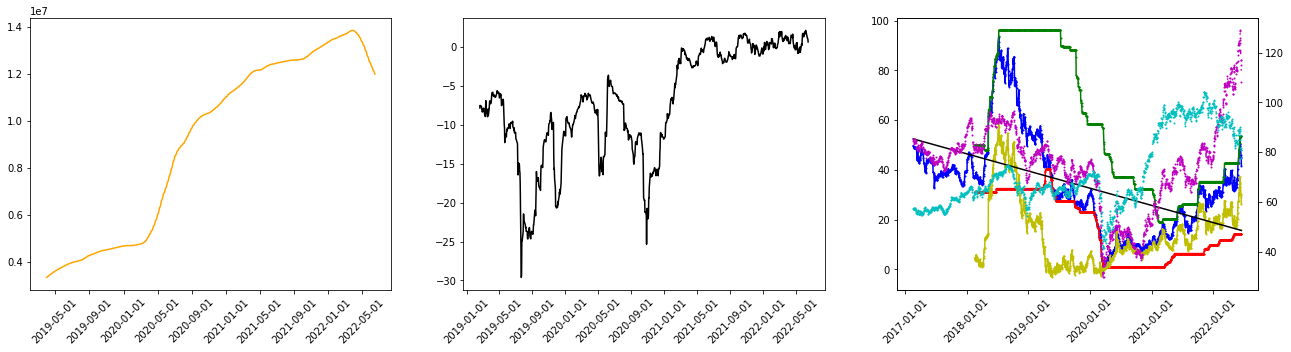

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 101.39949811580854 132.16950523588272
test cv mean error, stdev (10 folds): 108.73062213924891 136.47145070932157
sell date: 2022-08-07
expected return: 0.2110879822667285
discounted return: 0.003762336641273789
quarter return: 1.4126755527677608


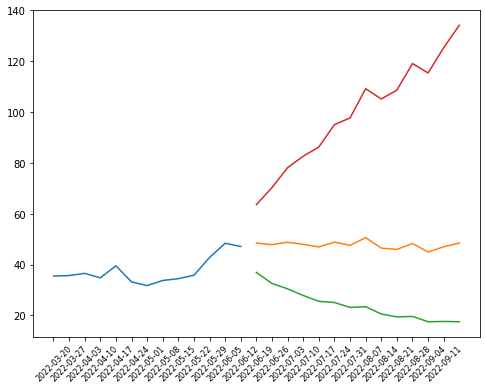

['options', ('2022-07-15', '2022-12-16')]
symbol: VLO
sector: Energy
Index: SP500
vol_30d_2yr: 90493904.4921875
Sector 1YMF: 28.05999755859375
1YMF: 28.05999755859375
risk trend factor: 0.5600798086468606
         beta currentRatio debtToEquity dividendRate dividendYield  \
VLO  1.762704        1.178       64.483         3.92        0.0306   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  \
VLO  6672999936       0.05306  10.321334   4647625216      0.05998   

    grossProfits heldPercentInstitutions                        industry  \
VLO   5487000000                 0.80541  Oil & Gas Refining & Marketing   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
VLO  47975763968        6498999808           0.0341      0.6312     0.36   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
VLO    2.549113                     0.381472       0.02019        0.7   

    returnOnAssets returnOnEquity revenueGrowth revenuePerSh

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  118.739998  117.280841  131.546349  145.811857  115.991905   

              90dSDev 90d_lower  90d_upper  
2022-06-16  14.921167  86.14957  145.83424

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VLO      1.276553  118.739998  90493904.492188  0.747957  0.703807  0.534876

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


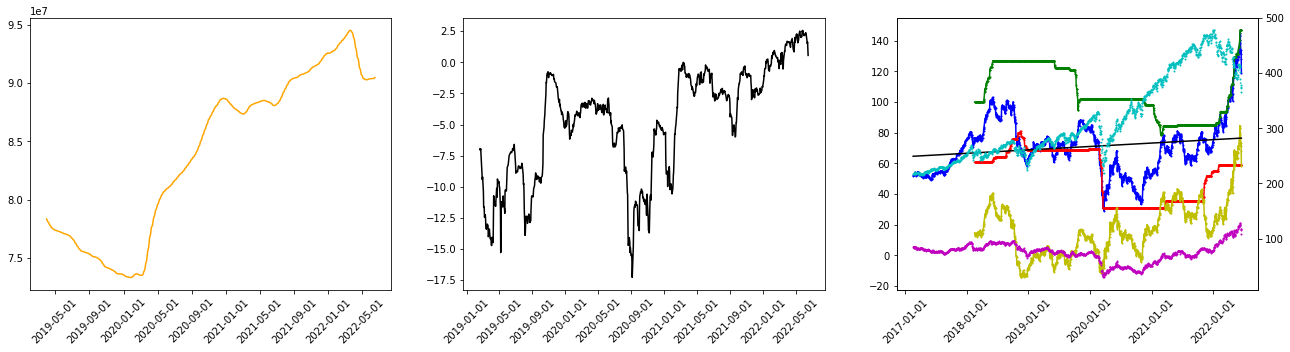

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 270.7288036125925 325.1657047316831
test cv mean error, stdev (10 folds): 289.08789990695357 335.55683349127474
sell date: 2022-09-18
expected return: 0.3490525834545268
discounted return: 0.0032245701000064297
quarter return: 1.3447164509936733


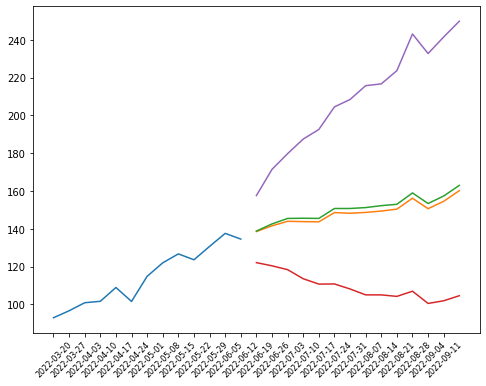

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.23
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        4.98
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              30.94
highestControversy                        3
esgPerformance                     OUT_PERF
coal                                  False
p

Adj Close     21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-16  185.740005  185.754726  186.945397  188.136069  178.58127   

              90dSDev   90d_lower   90d_upper  
2022-06-16  10.681952  157.217366  199.945174

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
PSB      2.625777  185.740005  2715957.617188  0.949237  0.808632  0.476969

Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


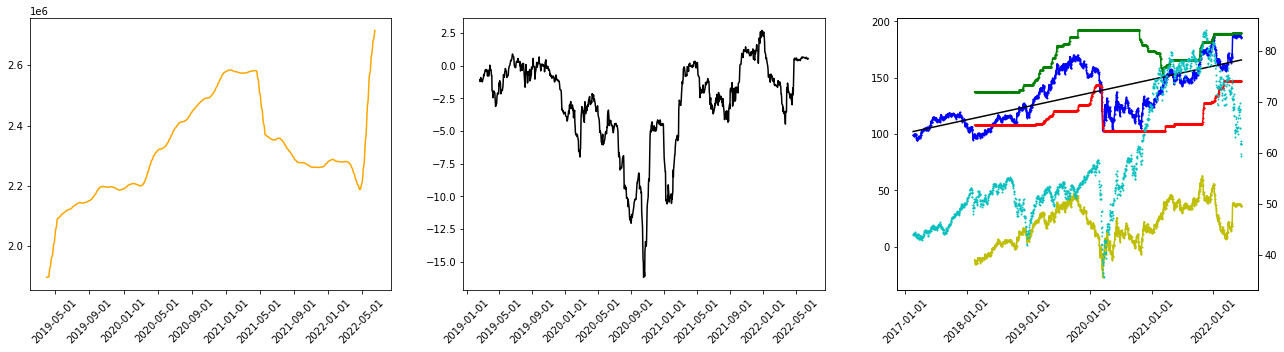

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 260.5063229360087 223.517550956187
test cv mean error, stdev (10 folds): 282.3883555495087 222.91040415313898
sell date: 2022-07-24
expected return: 0.02953459929905512
discounted return: 0.000786981258402708
quarter return: 1.0750571264961832


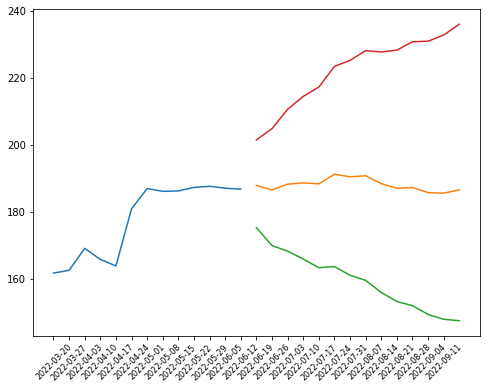

symbol: CIVI
sector: Energy
Index: SP600
vol_30d_2yr: 11253325.390625
Sector 1YMF: 14.15999984741211
1YMF: 14.15999984741211
risk trend factor: 0.4785399779962
         beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
CIVI  1.69646        0.505       11.399         1.85        0.0222  910931008   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CIVI       0.54408  5.807773    855249152      0.79951    731177000   

     heldPercentInstitutions       industry   marketCap operatingCashflow  \
CIVI                 1.04378  Oil & Gas E&P  7110930432         764176000   

     operatingMargins payoutRatio pegRatio priceToBook  \
CIVI          0.26443      0.2792      0.4    1.532868   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
CIVI                     4.247195       0.16167      0.477        0.06714   

     returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
CIVI        0.09524        1

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  66.389999  60.798991  74.142698  87.486406  65.525238  7.696477   

            90d_lower  90d_upper  
2022-06-16  50.132283  80.918193

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
CIVI      1.620286  66.389999  11253325.390625  0.740317  0.000353  0.475979

ADFuller H0 rejected @ .05, Mean Reverting TS
Month Mean Reverting buy signal


Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


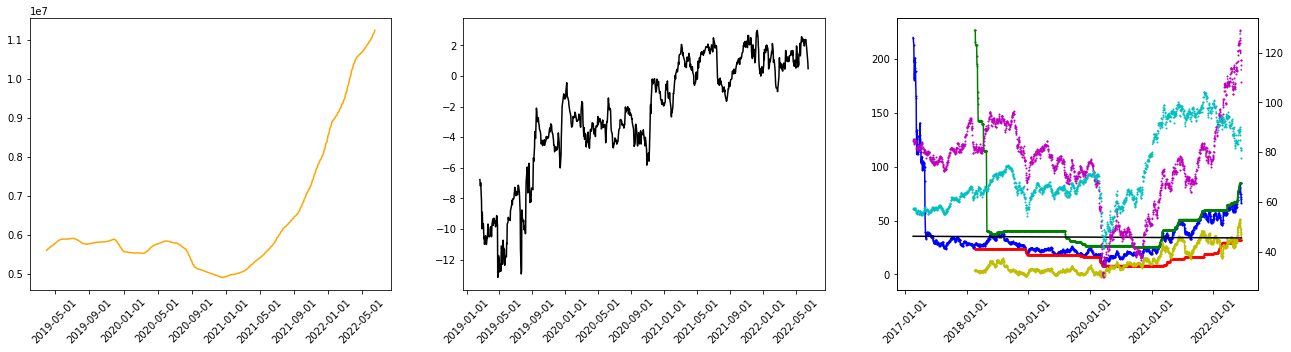

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 51.55359316545473 47.00561058314788
test cv mean error, stdev (10 folds): 55.55115663379006 47.4836507101994
sell date: 2022-09-18
expected return: 0.25538920657316877
discounted return: 0.002448645189316645
quarter return: 1.2523227125875087


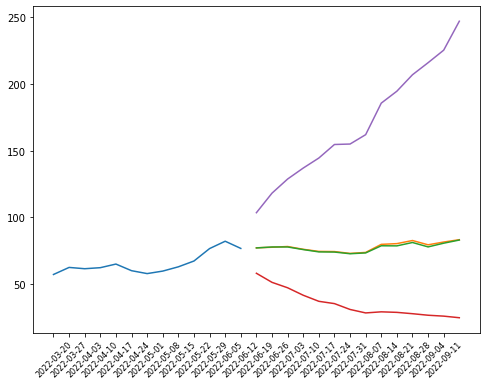

['options', ('2022-07-15', '2022-12-16')]
symbol: WRB
sector: Financial Services
Index: SP500
vol_30d_2yr: 24747816.40625
Sector 1YMF: 2.736675262451172
1YMF: 2.736675262451172
risk trend factor: 0.37904083099097574
         beta currentRatio debtToEquity dividendRate dividendYield  \
WRB  0.741517        0.453       44.413         0.35        0.0049   

    earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  \
WRB          1.585  1969144064       0.19279  15.017057   2491864832   

    grossMargins grossProfits heldPercentInstitutions  \
WRB      0.44661   4029355000                 0.69611   

                          industry    marketCap operatingCashflow  \
WRB  Insurance—Property & Casualty  18677542912        2350679040   

    operatingMargins payoutRatio pegRatio priceToBook  \
WRB          0.18096        0.07     1.94    2.720776   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
WRB                     1.828621       0.13546      0

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  66.300003  65.216512  68.971905  72.727298  67.901429  1.790878   

            90d_lower  90d_upper  
2022-06-16  64.319673  71.483184

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
WRB      1.151774  66.300003  24747816.40625  0.831215  0.938034  0.452933

Sector 1YMF: -73.55999755859375
Sector Volume Factor: 1.2176833027526361
Sector Risk Trend Factor: -3.976216084248311
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


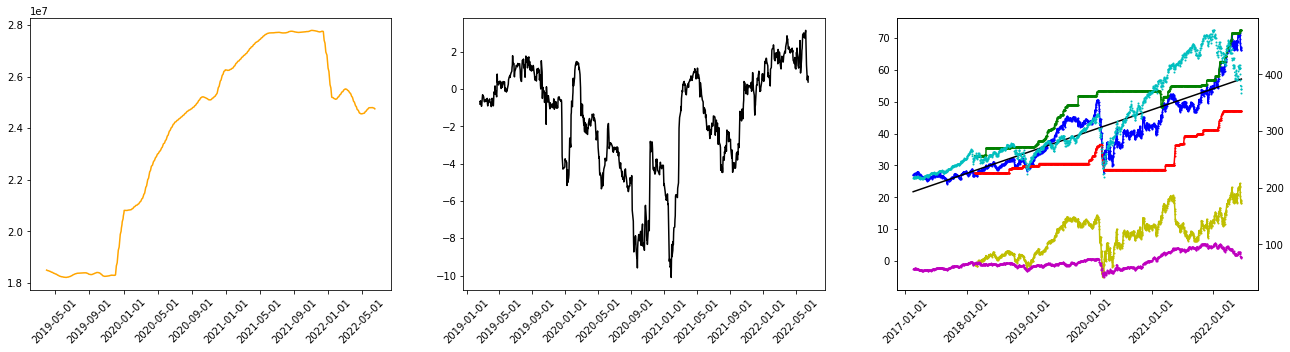

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 30.198218960642738 55.956222246869544
test cv mean error, stdev (10 folds): 32.81659318427742 58.0413126000435
sell date: 2022-09-18
expected return: 0.06968434856517591
discounted return: 0.0007246022212197278
quarter return: 1.068909814139557


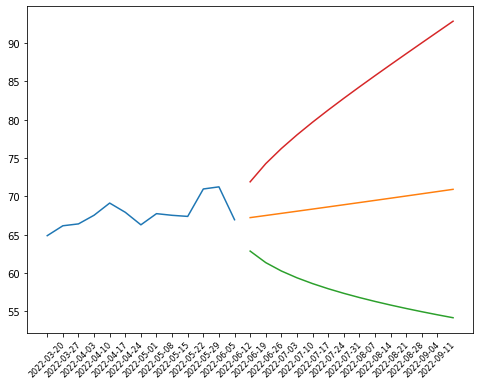

['options', ('2022-07-15',)]
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 7.83
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            12.16
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.95
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 31.22
peerGroup              Insurance
smallArms                  False
environmentScore            1.95
governancePercentile        None
militaryContract           F

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  72.650002  63.339915  77.245238  91.150561  73.864444  5.654845   

            90d_lower  90d_upper  
2022-06-16  62.554753  85.174135

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PDCE      1.200705  72.650002  24816581.054688  0.789239  0.542285  0.491711

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


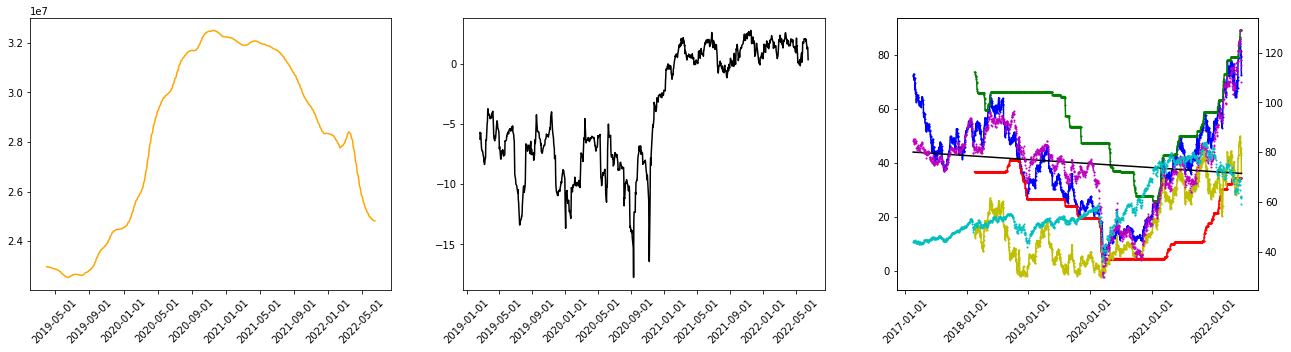

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 72.43226004354307 70.42731668177287
test cv mean error, stdev (10 folds): 73.99424076218664 73.68292785077412
sell date: 2022-09-18
expected return: 0.3062429711575351
discounted return: 0.002876764978065882
quarter return: 1.3024959962913203


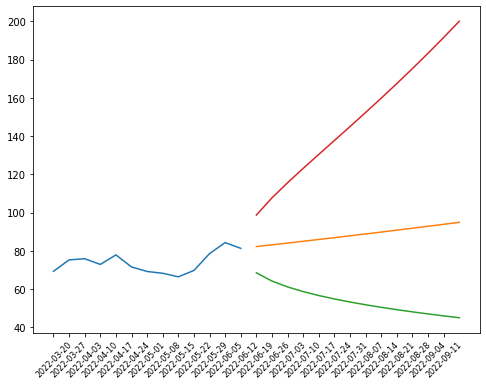

['options', ('2022-07-15', '2022-12-16')]
symbol: FANG
sector: Energy
Index: SP500
vol_30d_2yr: 60309967.578125
Sector 1YMF: 12.949966430664062
1YMF: 12.949966430664062
risk trend factor: 0.30484852653737765
          beta currentRatio debtToEquity dividendRate dividendYield  \
FANG  2.181941         0.72       42.218          2.8        0.0209   

     earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
FANG          2.278  5041999872       0.65762  5.376768    953625024   

     grossMargins grossProfits heldPercentInstitutions       industry  \
FANG      0.86683   5577000000                 0.91744  Oil & Gas E&P   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
FANG  22026260480        4572000256          0.48611      0.1272     0.35   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
FANG    1.747781                     2.872866       0.35751      0.656   

     returnOnAssets returnOnEquity revenueGrowth reve

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  133.679993  126.158293  146.608572  167.058851  139.299841   

             90dSDev   90d_lower   90d_upper  
2022-06-16  9.296925  120.705991  157.893691

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
FANG      1.031604  133.679993  60309967.578125  0.793954  0.668762  0.470333

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


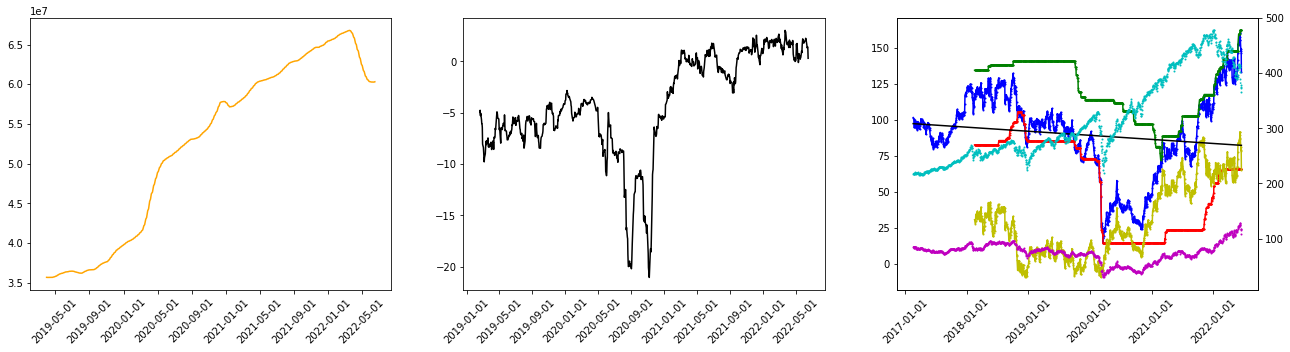

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 457.4652274706103 453.0765976406002
test cv mean error, stdev (10 folds): 492.34353754116444 460.8957296259948
sell date: 2022-09-18
expected return: 0.31657770133492685
discounted return: 0.0029617506689827433
quarter return: 1.312689841319238


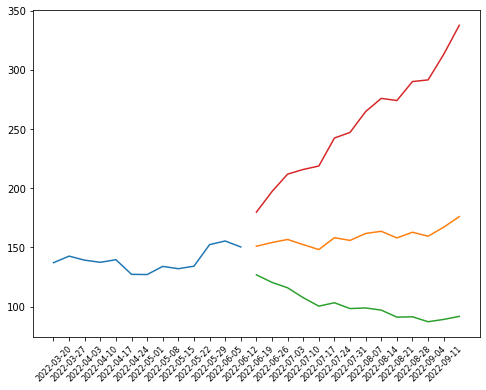

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: MANT
sector: Technology
Index: SP600
vol_30d_2yr: 4412490.234375
Sector 1YMF: 5.340003967285156
1YMF: 5.340003967285156
risk trend factor: 0.303581737515056
          beta currentRatio debtToEquity dividendRate dividendYield  \
MANT  0.737745        1.584       23.665         1.64          0.02   

     earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  \
MANT          -0.07  264191008       0.10344  25.047745     89507376   

     grossMargins grossProfits heldPercentInstitutions              industry  \
MANT      0.14856    379411000                 0.71066  Software—Application   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
MANT  3867116288         212171008          0.07374      0.4669     4.97   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
MANT    2.299301                     1.514167       0.05365      1.462   

     returnOnAssets returnOn

Adj Close    21dBOLD  21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-16  94.690002  94.152858  94.93635  95.719841  88.07254  5.500129   

            90d_lower  90d_upper  
2022-06-16  77.072281  99.072798

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MANT      2.896006  94.690002  4412490.234375  0.831136  0.565273  0.363266

Sector 1YMF: -374.97998046875
Sector Volume Factor: 1.137256537526499
Sector Risk Trend Factor: -4.4188079801718425
Index 1YMF: -79.04000854492188
Index Volume Factor: 1.243664249470528
Index Risk Trend Factor: -4.590013818867828


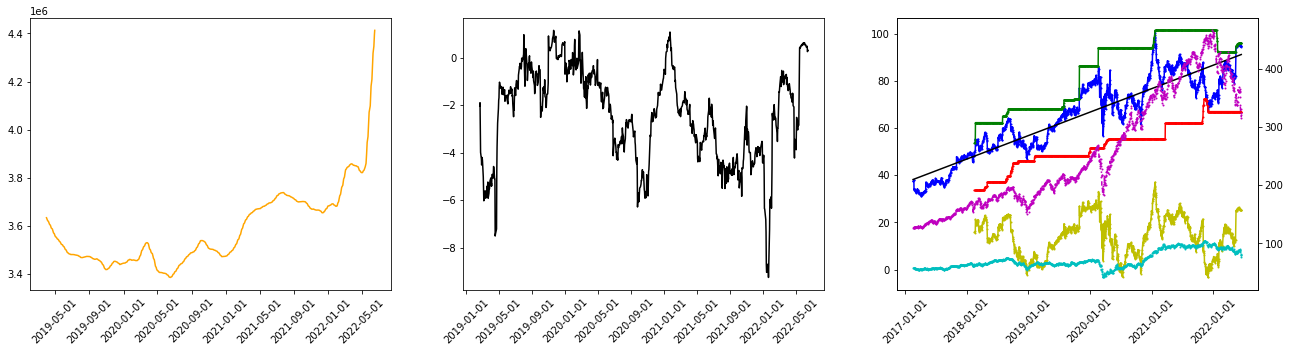

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 58.17583490436807 23.523585497775894
test cv mean error, stdev (10 folds): 55.63890437961787 23.192637782737986
sell date: 2022-08-21
expected return: 0.10862475555817906
discounted return: 0.0015877250755631511
quarter return: 1.1571439643699222


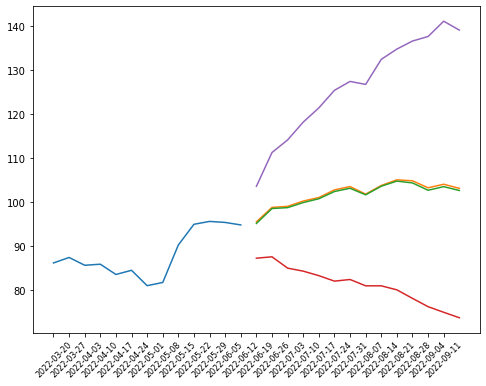

['options', ('2022-08-19',)]
symbol: FCN
sector: Industrials
Index: SP400
vol_30d_2yr: 6861602.34375
Sector 1YMF: 5.3899993896484375
1YMF: 5.3899993896484375
risk trend factor: 0.2867020486544266
         beta currentRatio debtToEquity earningsGrowth     ebitda  \
FCN  0.449509        2.395       36.191         -0.098  347764992   

    ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
FCN        0.1236  22.009373    171587632      0.31042    860715000   

    heldPercentInstitutions             industry   marketCap  \
FCN                 1.07223  Consulting Services  5637372416   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
FCN         318288992           0.1075           0     3.02    3.541487   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
FCN                      2.00364       0.08167      2.147        0.06601   

    returnOnEquity revenueGrowth revenuePerShare       sector  \
FCN        0.15126      

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-16  162.949997  159.096915  165.289047  171.48118  162.142381   

             90dSDev   90d_lower   90d_upper  
2022-06-16  5.101274  151.939833  172.344928

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
FCN      0.661624  162.949997  6861602.34375  0.874839  0.916688  0.405187

Sector 1YMF: -141.6699981689453
Sector Volume Factor: 0.8731518814579678
Sector Risk Trend Factor: -4.0477142333984375
Index 1YMF: -70.88999938964844
Index Volume Factor: 0.5662453634524328
Index Risk Trend Factor: -4.411325496943257


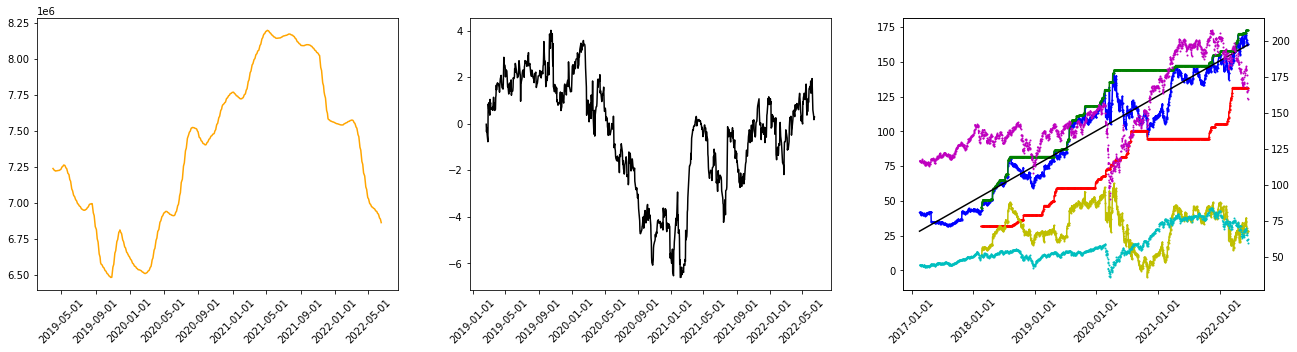

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 118.0983398047112 50.90102071587315
test cv mean error, stdev (10 folds): 116.6189746761398 53.05092522378669
sell date: 2022-09-18
expected return: 0.05665658999513497
discounted return: 0.0005927537047132336
quarter return: 1.0560306239304988


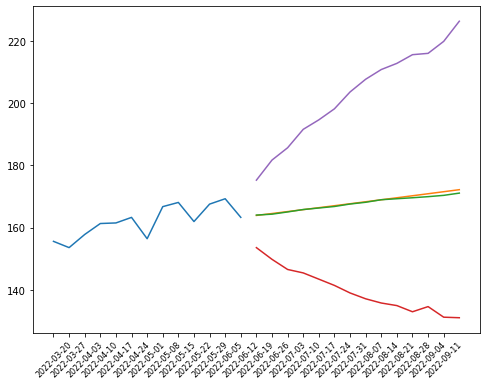

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Intangible Assets          2.964700e+07  3.199000e+07  3.450400e+07   
Total Liab                 1.327273e+09  1.517588e+09  1.462621e+09   
Total Stockholder Equity   1.622018e+09  1.583321e+09  1.544303e+09   
Deferred Long Term Liab    7.000000e+05  9.000000e+05  1.000000e+06   
Other Current Liab         4.011300e+07  9.977400e+07  3.627900e+07   
Total Assets               2.949291e+09  3.100909e+09  3.006924e+09   
Common Stock               3.450000e+05  3.430000e+05  3.430000e+05   
Retained Earnings          1.756704e+09  1.698156e+09  1.659947e+09   
Other Liab                 2.630210e+08  2.662880e+08  2.652540e+08   
Good Will                  1.243972e+09  1.232791e+09  1.234023e+09   
Treasury Stock            -1.350310e+08 -1.288400e+08 -1.244770e+08   
Other Assets               1.063720e+08  1.079430e+08  1.120850e+08   
Cash                       2.711430e+08  4.944850

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-16  56.810001  58.485433  66.067619  73.649805  61.391111  4.682746   

            90d_lower  90d_upper  
2022-06-16  52.025619  70.756603

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
OXY      1.143644  56.810001  499589648.4375  0.737027  0.695678  0.543336

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


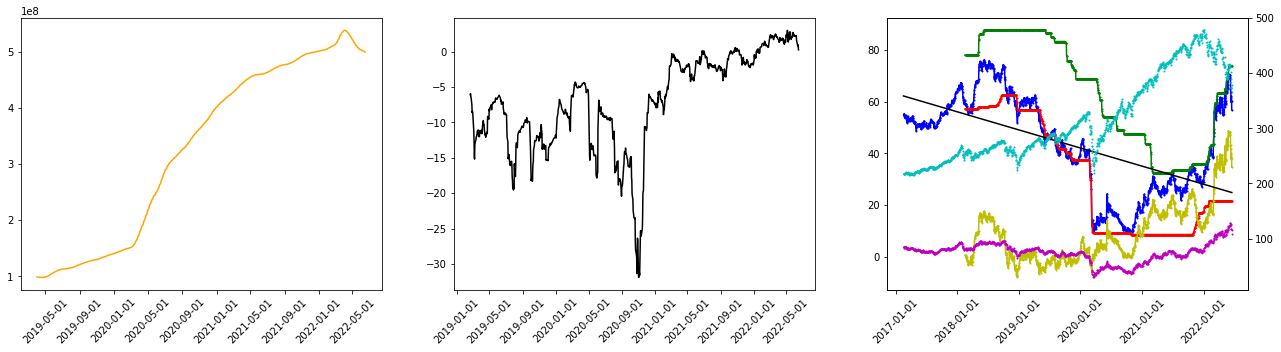

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 57.70265041885063 48.314589303389745
test cv mean error, stdev (10 folds): 59.40587885682551 50.35691248755781
sell date: 2022-06-19
expected return: 0.07687864809426415
discounted return: 0.03772763675940727
quarter return: 30.176664717766005


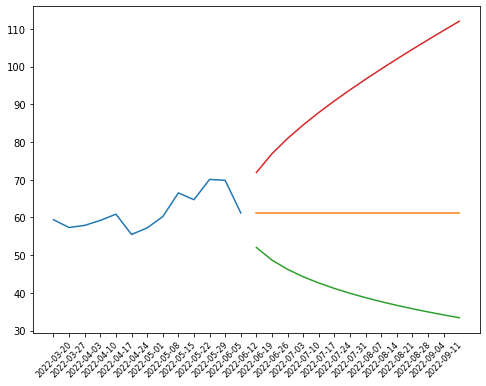

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   1.674900e+10  1.669200e+10  1.663800e+10   
Total Liab                        5.470900e+10  5.688500e+10  6.169300e+10   
Total Stockholder Equity          1.056500e+10  9.111000e+09  8.482000e+09   
Other Current Liab                6.930000e+08  1.037000e+09  1.120000e+09   
Total Assets                      7.503600e+10  7.575800e+10  7.993700e+10   
Common Stock                      2.170000e+08  2.170000e+08  2.170000e+08   
Other Current Assets              1.288000e+09  2.590000e+09  3.150000e+09   
Retained Earnings                 4.480000e+09  3.152000e+09  2.533000e+09   
Other Liab                        1.593300e+10  1.583900e+10  1.546200e+10   
Treasury Stock                   -1.088100e+10 -1.095000e+10 -1.090600e+10   
Other Assets                      1.231000e+09  1.145000e+09  1.138000e+09   
Cash                              2.

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-16  119.559998  118.328371  134.179842  150.031312  125.279683   

             90dSDev   90d_lower   90d_upper  
2022-06-16  8.564534  108.150615  142.408751

volume_factor    latest_p      vol_30d_2yr  pct_2yr       adf     hurst
EOG      0.870698  119.559998  97161242.382812  0.75653  0.682764  0.481992

Sector 1YMF: 14.330001831054688
Sector Volume Factor: 0.8279694389405757
Sector Risk Trend Factor: 0.4625564970394849
Index 1YMF: -285.47003173828125
Index Volume Factor: 1.1872171829536644
Index Risk Trend Factor: -3.322122130654123


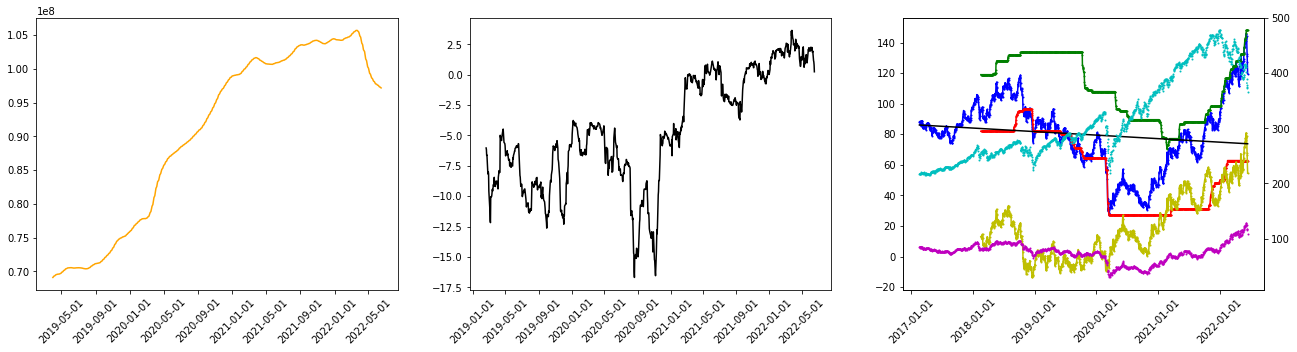

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 288.97414681128515 278.7251158990426
test cv mean error, stdev (10 folds): 315.81934829270745 278.44056096026753
sell date: 2022-06-19
expected return: 0.14157883351619116
discounted return: 0.06844692592388091
quarter return: 441.8468431168764


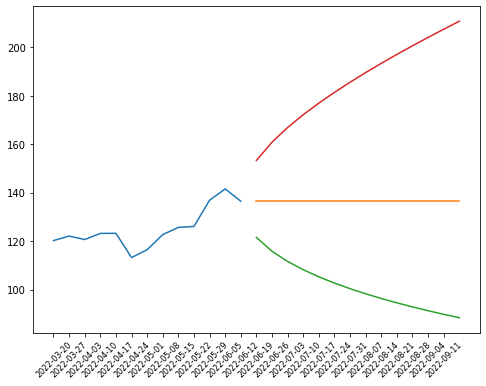

['options', ('2022-07-15', '2023-01-20', '2024-01-19', '2026-03-20')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.13
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.73
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             36.25
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticid

In [137]:
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

client = Client('192.168.3.100:8786')

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
decision_metrics = []

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in list__:

    #for s in ['CEIX']:
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s]

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("vol_30d_2yr:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    #print("1YMF:",subset['1YMF'].values[-1])
    print("Sector 1YMF:",screener[screener.index==s]['1YMF'][0])
    print("1YMF:",screener.iloc[np.where(screener.index==s)]['1YMF'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)

    mean_revert_flag = False

    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True    

    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(22,5))
    ax1.plot(subset['30d_vol_2yr'],color='orange')
    ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)


    ax1.xaxis.set_major_formatter(date_form)

    #plt.title('30d_vol_2yr')
    ax2.plot(subset['risk_trend_factor'],color='black')
    ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)

    ax2.xaxis.set_major_formatter(date_form)
    #plt.title('risk_trend_factor')

    #fig, ax1 = plt.subplots()   

    ax4 = ax3.twinx()

    if(symbol_sector=='error'):
        pass
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])            
            print("Sector 1YMF:",screener[screener.index==symbol_sector]['1YMF'][0])
            print("Sector Volume Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['volume_factor'][0])
            print("Sector Risk Trend Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['risk_trend_factor'][0])
            ax4.plot(x, (prices[prices['Symbol']==symbol_sector]['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
            #ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            print("Index 1YMF:",screener[screener.index==temp_sm.loc[s]['index_Symbol']]['1YMF'][0])
            print("Index Volume Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['volume_factor'][0])
            print("Index Risk Trend Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['risk_trend_factor'][0])

            ax4.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

    ax3.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

    ax3.plot(x, mymodel, color = 'k')

    #for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
        #labels.append(l)

    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    

    ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)

    ax3.xaxis.set_major_formatter(date_form)
    plt.show()

    print("ets next 13 weeks")

    newDates = pd.date_range(end, (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W').map(lambda t: t.strftime('%Y-%m-%d'))

    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W')

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()

    cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

    #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
    cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

    outer_results = []

    #sm.tsa.statespace.ExponentialSmoothing
    """
    flags = []
    seasonal_flags1 = ['add','mul',None]

    trend_flags2 = ['add','mul',None]

    damped__trend_flags3 = [True,False]

    for sf in seasonal_flags1:
        for dt_ in trend_flags2:
            if(dt_ is None):          
                for d_ in damped__trend_flags3:
                    flags.append([sf,dt_,d_])
    """

    flags = [['add', 'add', True],\
     ['add', 'add', False],\
     ['add', 'mul', True],\
     ['add', 'mul', False],\
     ['add', None],\
     ['mul', 'add', True],\
     ['mul', 'add', False],\
     ['mul', 'mul', True],\
     ['mul', 'mul', False],\
     ['mul', None],\
     [None, 'add', True],\
     [None, 'add', False],\
     [None, 'mul', True],\
     [None, 'mul', False],\
     [None, None]]

    #print(flags)

    #flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

    rmse_inner_flags = []

    for flag in flags:

        npa = []

        for trainv_ix, test_ix in cv_inner.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,flag])

        future = client.map(evaluate_ets, npa)        

        rmses_inner = []
        #flag_order = []
        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                #this causes errors with [flag,rmse] being passed by evaluate_ets
                rmses_inner.append([np.nan])
            else:
                rmses_inner.append(f.result())

        #I don't want to keep track of flag here
        #flag_order = [r[0] for r in results_rmses].copy()

        rmse_ = [r[1] for r in rmses_inner].copy()
        #print(rmse_)
        #print(flag)
        rmse_inner_flags.append([flag,np.nanmean(rmse_),np.nanstd(rmse_)])

    #rmse_scores = []
    #flag_rmses = []

    #for fn_ in range(0,len(flags)):
        #flag_ = flags[fn_]
        #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

    print("inner cv scores:")
    inner_rmse_df = pd.DataFrame(rmse_inner_flags,columns=['flags','mean','std'])
    #print("inner cv scores:",[r[rmses)
    #print("inner cv sdevs:",sdevs)

    scores = inner_rmse_df['mean'].values
    sdevs = inner_rmse_df['std'].values
    best_model = inner_rmse_df['flags'].values[np.argmin(scores)]

    print("best model:",best_model)
    print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

    npa = []

    for trainv_ix, test_ix in cv_outer.split(data.index):

        npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,best_model])

    future = client.map(evaluate_ets, npa)
    results_rmses_outer = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses_outer.append([np.nan])
        else:
            results_rmses_outer.append(f.result()) 

    test_score_mean = np.nanmean([r[1] for r in results_rmses_outer])
    test_score_std = np.nanstd([r[1] for r in results_rmses_outer])

    #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
    print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)
    
    #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    
    flag = best_model
    if(len(flag)==2):
        if(flag[1] is None):
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=data.index).fit()
        else:
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=data.index).fit()
    else:
        final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=data.index).fit()
        
    df_pred = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())
    #df_conf = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).pred_int(alpha = .05))
    #df_conf.columns = ['ci_lower','ci_upper']
    
    #final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=['add','mul','None'][0],seasonal_periods=52,trend=['add','mul','None'][0],damped_trend=['True','False'][0],dates=data.index).fit()
    #pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    
    #final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame()
    
    #df_pred = np.exp(pred.summary_frame(alpha=0.05))
    #df_pred = np.exp(pred.summary(alpha=0.05))
    s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')
    
    print("sell date:",s_date)
    e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
    p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['mean'].values)]).T
    #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
    #print(c_metrics)
    print("expected return:",e_return)
        
    days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
    discounted_return = (1+e_return)**(1/days_delta)-1
    qtr_return = (1+discounted_return)**92

    print("discounted return:",discounted_return)
    
    print("quarter return:",qtr_return)
    
    #used to help filter at the end, not sdevs is chosen based on min score
    decision_metrics.append([s,e_return,s_date,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
    
    plt.plot(data.tail(13))
    plt.plot(df_pred)
    #plt.plot(df_conf)
    plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.show()

    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()    

11

In [143]:
decision_metrics_df = pd.DataFrame(decision_metrics,columns=['SYMBOL','exp_return','sell_date','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','pi_lower','pi_upper'])
decision_metrics_df = decision_metrics_df.set_index('SYMBOL').sort_values(by='disc_rtn',ascending=False)
decision_metrics_df['price'] = screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['Sector'] = temp_sm['Sector'].loc[decision_metrics_df.index]
decision_metrics_df['Index'] = temp_sm['index'].loc[decision_metrics_df.index]
decision_metrics_df['error_price_ratio'] = decision_metrics_df['outer_cv_avg_rmse_n11']/screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['std_price_ratio'] = decision_metrics_df['outer_cv_std_n11']/screener['latest_p'].loc[decision_metrics_df.index]

In [144]:
display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', 
                  subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))